### Filter Balance ###

In terms of survey strategy, "filter balance" refers to the distribution of visits between different filters (not considering any time dependency). The previous round of survey strategy evaluation (phase 1) found no strong obvious driver for changing the default filter balance for the low-dust WFD region, although mini-surveys do have different filter balance requests. There were some questions as to whether more time spent on bluer filters would be beneficial, primarily driven by Cadence Notes submitted for science studies of star forming galaxies, blue transients, and turn-off stars in the Milky Way. 

The v2.0 simulations include one family where the low-dust WFD region is skewed towards more blue (u and g) band visits. The filter balance isn't directly addressed in the longer u band visits family, but these and the 'good seeing' family are worth checking with similar metrics; these other families don't directly vary the number of visits in each bandpass, but longer u-band visits do have implications for visit depths and/or number of visits, and the typical visit depths can change as a result of changing the redistributing visits over different seeing bands.

In [5]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import healpy as hp
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline

In [136]:
families = maf.archive.get_family_descriptions()
family_list = families.index.values
summary_source = 'summary_2022_04_28.csv'
summaries = maf.get_metric_summaries(summary_source=summary_source)
metrics_source = 'metric_sets.json'
metric_set = maf.get_metric_sets(metrics_source)

It may be helpful to show the region of the sky in question (the low-dust WFD) and then summarize some information about the current distribution of visits per band and their median depths, in each of these simulations. 
This is just presenting background information about the filter balance. 

In [13]:
opsdb = get_baseline()
runName = os.path.split(opsdb)[-1].replace('.db', '')

filterlist = ['u', 'g', 'r', 'i', 'z', 'y']
m = maf.CountMetric(col='observationStartMJD', metricName='Nvisits', units='')
s = maf.HealpixSlicer(nside=64)
nvisits = {}
for f in filterlist:
    print("running {f} band")
    sql = f"filter = '{f}'"
    nvisits[f] = maf.MetricBundle(m, s, sql,
                                  runName=runName,
                                  info_label=f'{f}',
                                  plotDict={'percentileClip': 95})
g = maf.MetricBundleGroup(nvisits, opsdb, outDir='temp', verbose=False)
g.runAll()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


0.0 180.0 -180.0 180.0


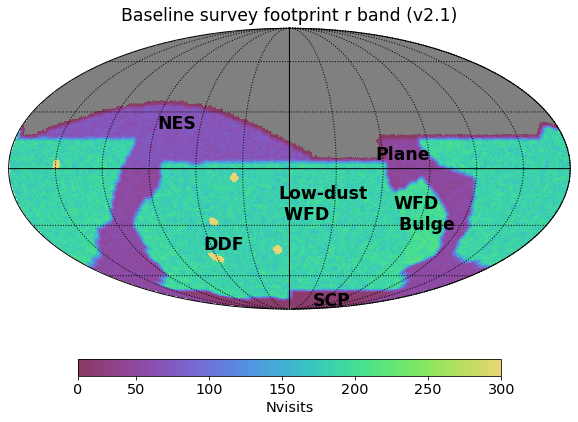

In [46]:
## Skymap with regions labelled
f = 'r' # bandpass
figformat = 'png'
ph = maf.PlotHandler(savefig=False, figformat=figformat, thumbnail=False, dpi=270, outDir='temp')
ph.setMetricBundles([nvisits[f]])
ph.plot(plotFunc=maf.plots.HealpixSkyMap(), 
        plotDicts={'colorMin': 10, 'colorMax':300, 'figsize': (8, 7),  'nTicks': 7,
                   'labelsize': 'x-large', 'fontsize':'x-large', 'xlabel': "Nvisits"})
plt.figtext(0.49, 0.42, 'Low-dust\n WFD', fontsize='xx-large', fontweight='bold')
plt.figtext(0.28, 0.6, r'NES', fontsize='xx-large', fontweight='bold')
plt.figtext(0.69, 0.40, 'WFD\n Bulge', fontsize='xx-large', fontweight='bold')
plt.figtext(0.66, 0.54, r'Plane', fontsize='xx-large', fontweight='bold')
plt.figtext(0.55, 0.25, r'SCP', fontsize='xx-large', fontweight='bold')
plt.figtext(0.36, 0.36, r'DDF', fontsize='xx-large', fontweight='bold')
plt.title(f'Baseline survey footprint {f} band (v2.1)', fontsize='xx-large', fontweight='normal')
# We have to save the figure separately, because otherwise labels aren't getting saved.
plt.savefig(os.path.join('temp', f'{runName}_nvisits.{figformat}' ), 
            facecolor='w', edgecolor='w', bbox_inches='tight',dpi=270, format=figformat)

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


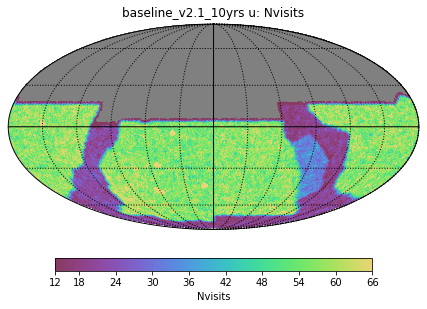

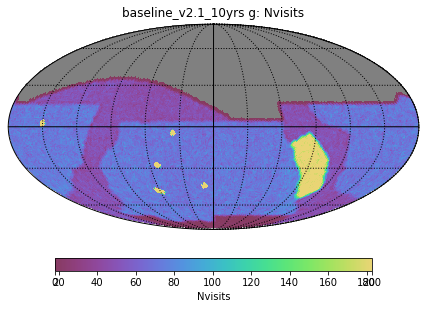

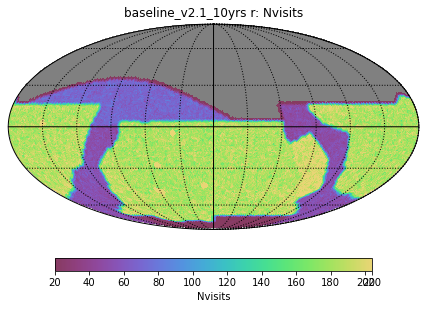

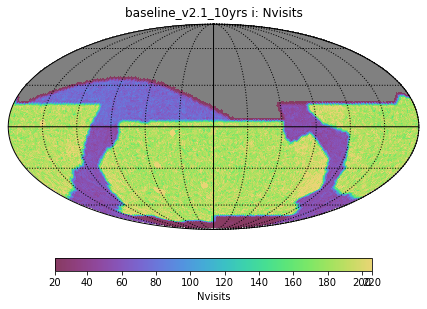

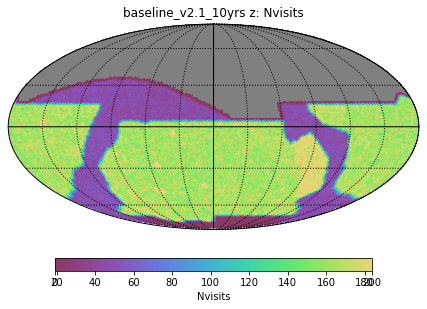

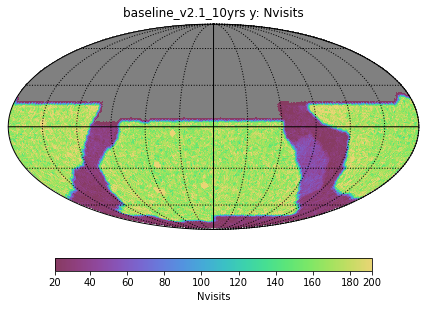

In [47]:
# Note some of the differences in different bandpasses - WFD Bulge is heavier in g, lighter in y for example,
# the background/dusty plane matches the WFD bulge balance, and the NES has no u or y band coverage
# (this is not the particular 'filter balance' in question here, but is useful to know)
ph = maf.PlotHandler()
for f in filterlist:
    ph.setMetricBundles([nvisits[f]])
    ph.plot(plotFunc=maf.HealpixSkyMap())

In [78]:
# Families that seem most relevant to check here
fam = ['bluer balance', 'longer u visits', 'good seeing']
baseline_run = 'baseline_v2.0_10yrs'
these_runs = np.concatenate([[baseline_run], families.explode('run').loc[fam, 'run']])
lines = np.concatenate([[0],maf.find_family_lines(families, fam)[:-1],[11]]) + 1

In [64]:
maf.describe_families(families.loc[fam, :],
                        summary=summaries,
                        table_metric_set=metric_set.loc["short description"],
                        plot_metric_set=None,
                        baseline_run=baseline_run)

---
**bluer balance** : The standard filter balance in the dust-free WFD in the baseline is {'u': 0.07, 'g': 0.09, 'r': 0.22, 'i': 0.22, 'z': 0.20, 'y': 0.20}. These simulations vary the filter balance, skewing it bluer. One simulation adds visits to g band,while the other adds visits to both u and g band, in each case by taking some visits from rizy.  
**version**: 2.0  
**runs**:  


---
**longer u visits** : The baseline survey uses 2x15s visits for all bands except u band. In the baseline, u band visits are 1x30s to reduce the effects of readnoise (which are most extreme in u, due to the low sky-background). These simulations extend the u band visit time further, to 1x50s. In one simulation, the total amount of survey time spent on u band is kept the same, so the number of visits is reduced accordingly. In the other simulation, more survey time is spent in u band in order to maintain the number of visits in u.  
**version**: 2.0  
**runs**:  


---
**good seeing** : This family of simulations adds a requirement for 3 "good seeing" (seeing < 0.8 arcseconds) images per year, in various bandpasses. Note that `baseline_v2.1_10yrs` (and other v2.1 simulations) adds this requirement in r and i bands as the default.  
**version**: 2.1  
**runs**:  


(None, None)

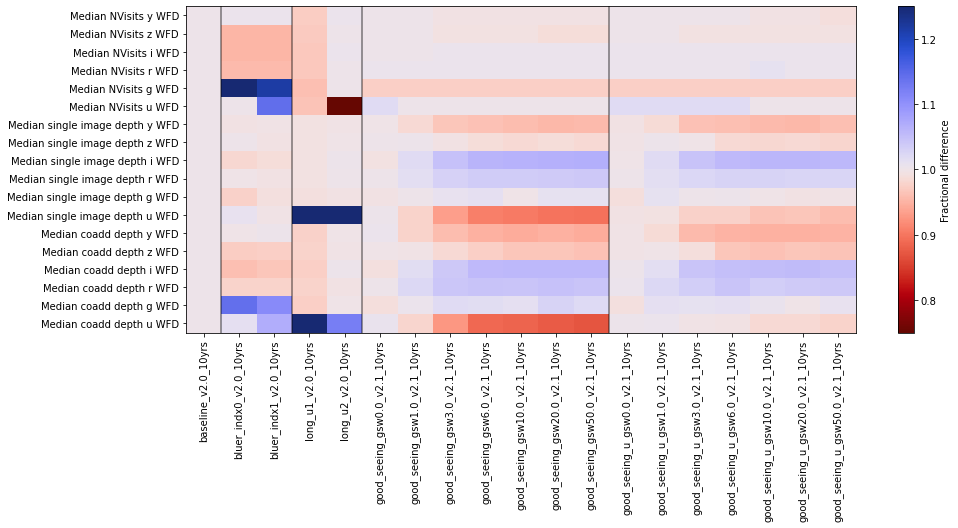

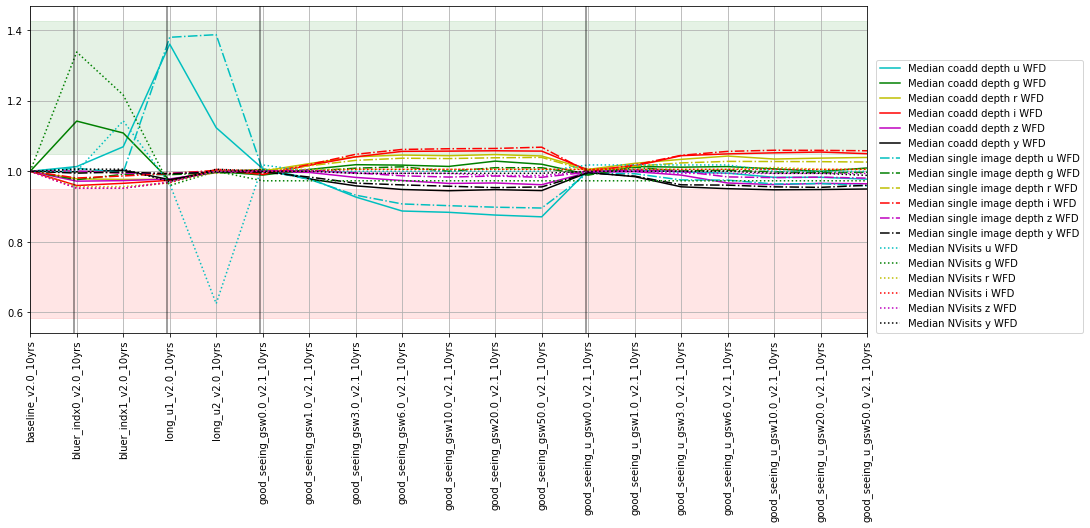

In [137]:
k = 'WFD Depths'

# Plot two versions of the figures
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=metric_set.loc[k]['short_name'],
                                   metric_set=metric_set.loc[k],
                                  color_range=0.5)
fig.set_figwidth(15)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                              baseline_run=baseline_run,
                              metric_set=metric_set.loc[k],
                              metric_label_map=metric_set.loc[k]['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(15)
#ax.set_ylim(0.5, 1.5)
lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
for l in lines:
    ax.axvline(l-0.05, color='k', alpha=0.5)

The shifts you see above in the number of visits per band and the depths per image per band in the 'good seeing' series is why I think they are worth looking at here. The primary question does still revolve around the first two variations on the left of these plots (bluer_indx0 and bluer_indx1 from the 'bluer balance' family). 

I did look at these metrics across all of the other families of runs. Some of them are not really comparable -- adding microsurveys will throw off some of these metrics because they don't remove short visits, for example, and increasing the galactic plane footprint weight to the WFD-level makes it "count" as WFD, which changes the reported filter balance (but really this is only for part of the sky). The triplets family do change the image depths significantly, but this is due to the change in visit timing in the night, rather than truly due to changing how the visits are distributed between filters. The impact of the triplet and long gaps no pairs families are worth checking static science metrics against, but could be thought of as a separate question.

### Metrics ###

There are many considerations around the filter balance, but the primary drivers towards a bluer balance (from the previous Cadence Notes) were studies of star forming galaxies, turn-off stars and blue transients. 

We do have some transient metrics that should include blue transients (or at least that require blue band observations to identify the transient). We do not currently have metrics that specifically target identification of star forming galaxies, although we do have a metric looking at the expected total number of galaxies (in i band, but we can start running this in all bands). Similarly, I do not believe we have a metric looking at turn-off stars specifically, although we do have metrics that look at the overall number of stars. 

So, we can go through the other metrics we do have to look for impacts (note we do not have a photo-z metric; Melissa Graham has some photo-z code she runs on the median coadded depths per filter to evaluate photo-z values, but it's intensive to both run and evaluate, and so not easy to run on the whole sky). 


In [138]:
# List the metric sets so far (there are more metrics available though, but we have so far grouped them up this way)

msets = list(metric_set.groupby('metric set').first().index)
msets

for k in msets:
    print(k, len(metric_set.loc[k]))
    # Check that the metrics are correctly named and in the summary file
    summaries.loc[:, metric_set.loc[k]['metric']]

AGN N QSO 6
AGN SF 12
AGN SF DDF 30
AGN timelag 12
DESC SN DDF 15
DESC WFD 9
GP season 6
GP visit 6
N Visits 9
SL TDC 6
SRD 5
SSO N Objs 6
SSO discovery 14
SSO discovery options 22
SSO fraction 3 bands 14
SSO fraction 4 bands 14
SSO fraction 5 bands 14
SSO fraction 6 bands 14
SSO lightcurve inversion 8
Stars 6
TVS KNe 7
TVS PeriodDetect 6
TVS PeriodModulation 8
TVS Presto 2
TVS TDE 5
TVS XRB 3
TVS microlensing 4
TVS microlensing all 27
TVS short 8
WFD Depths 18
cadence 8
galaxies 1
plot areas 5
radar 13
short description 10


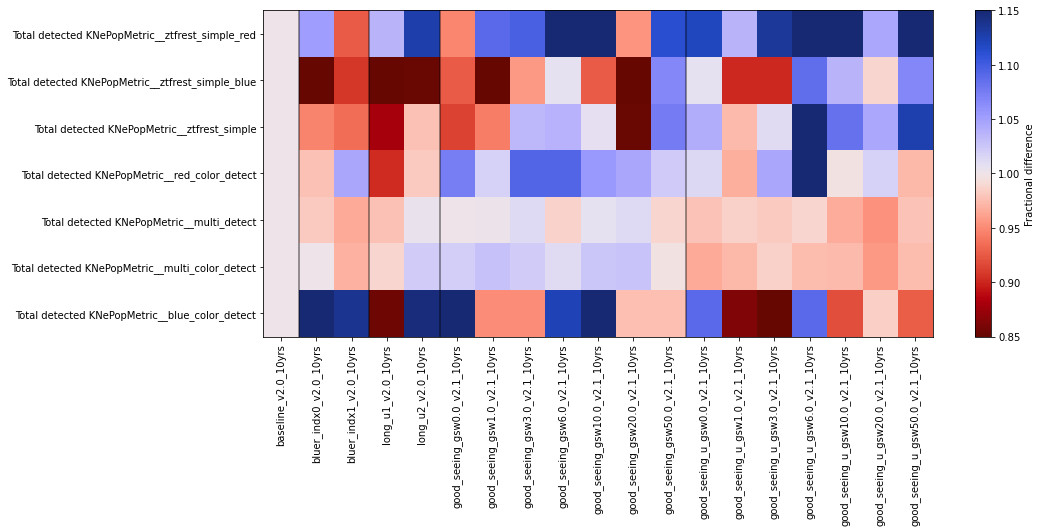

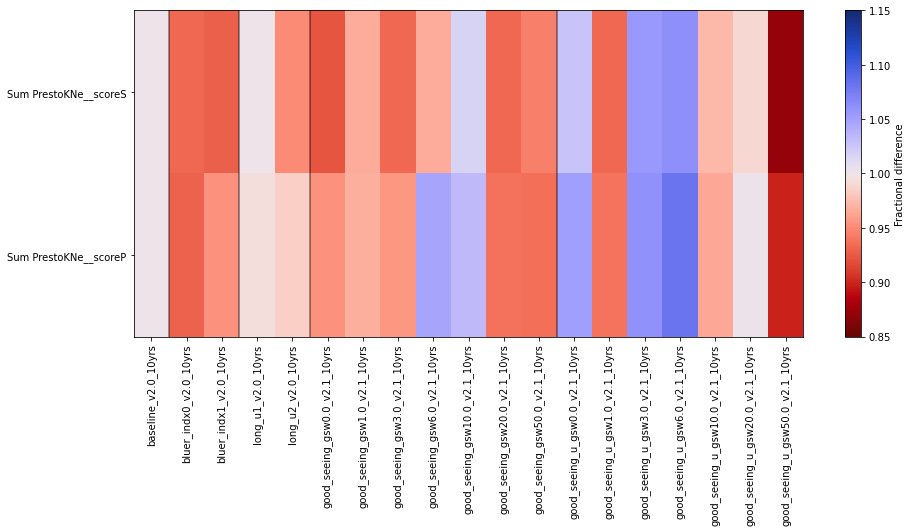

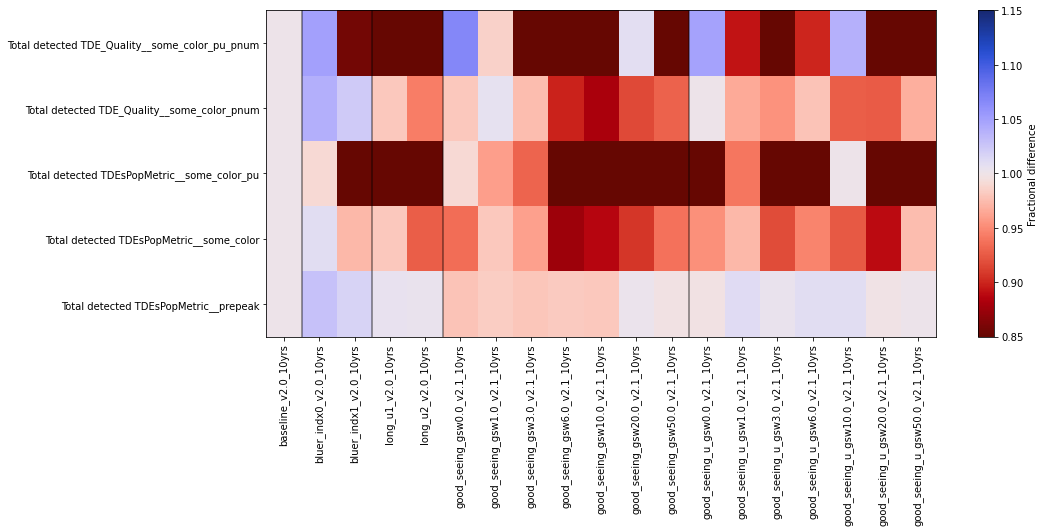

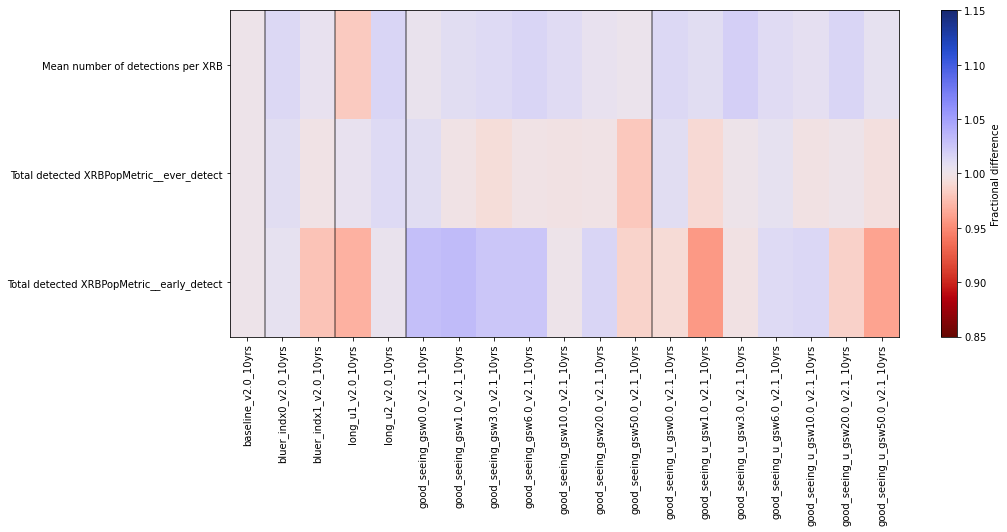

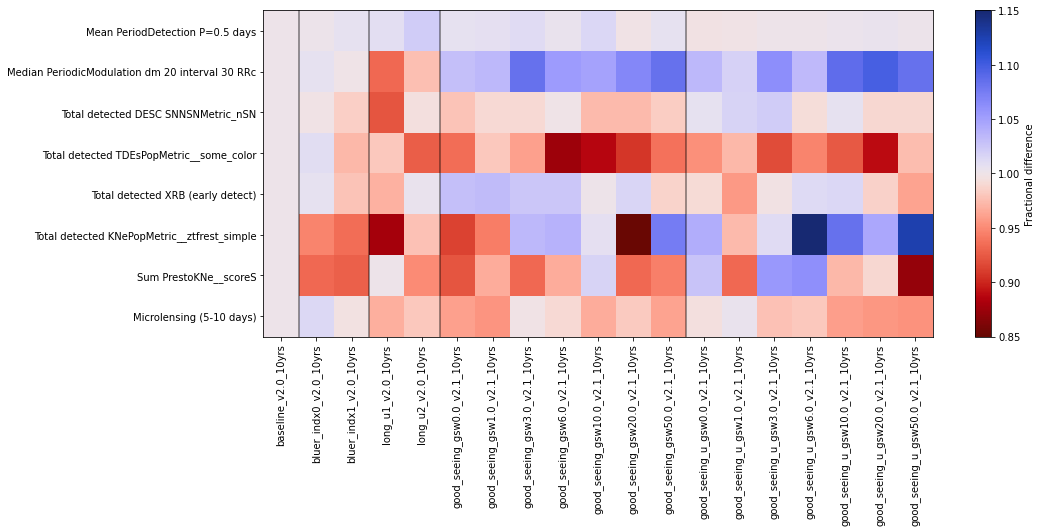

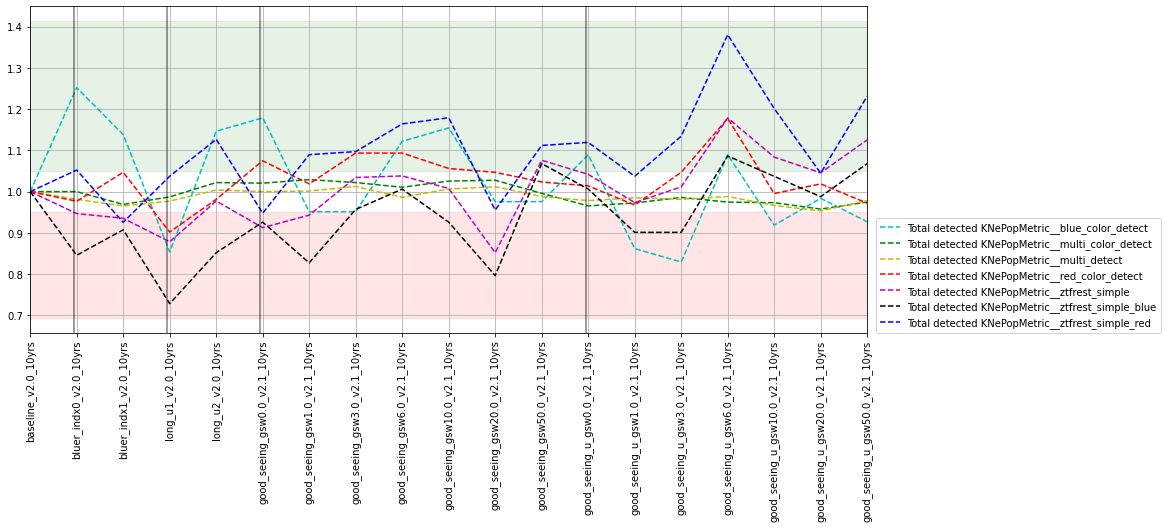

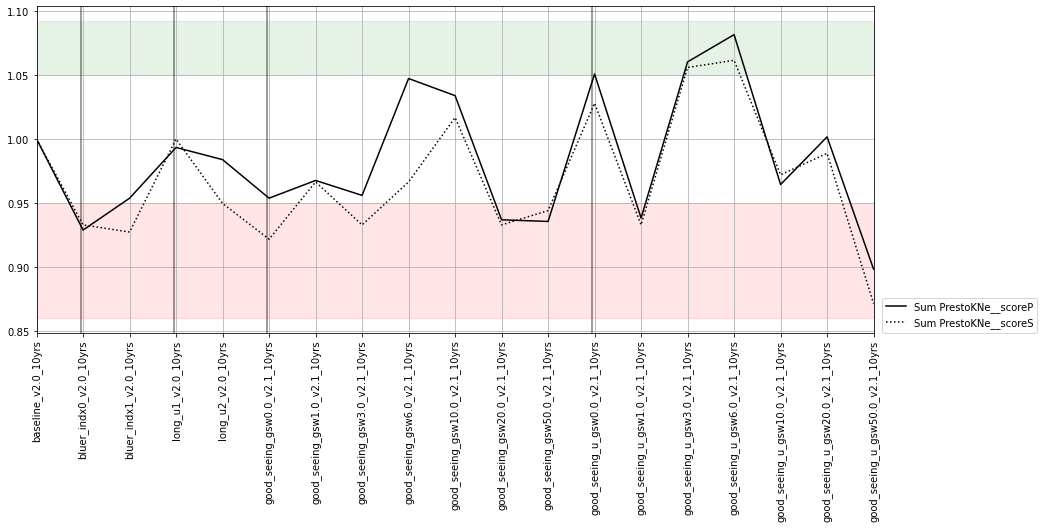

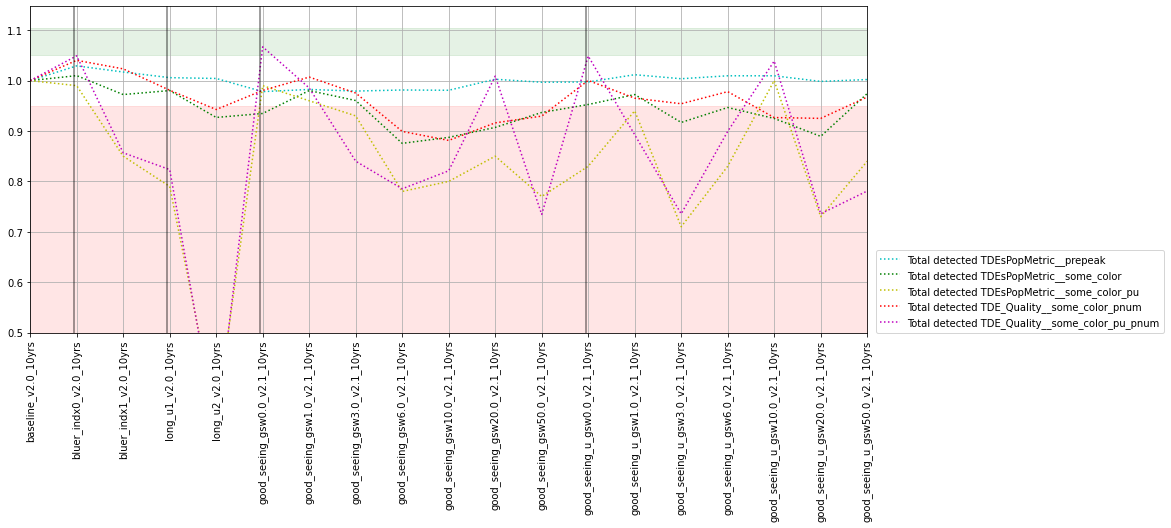

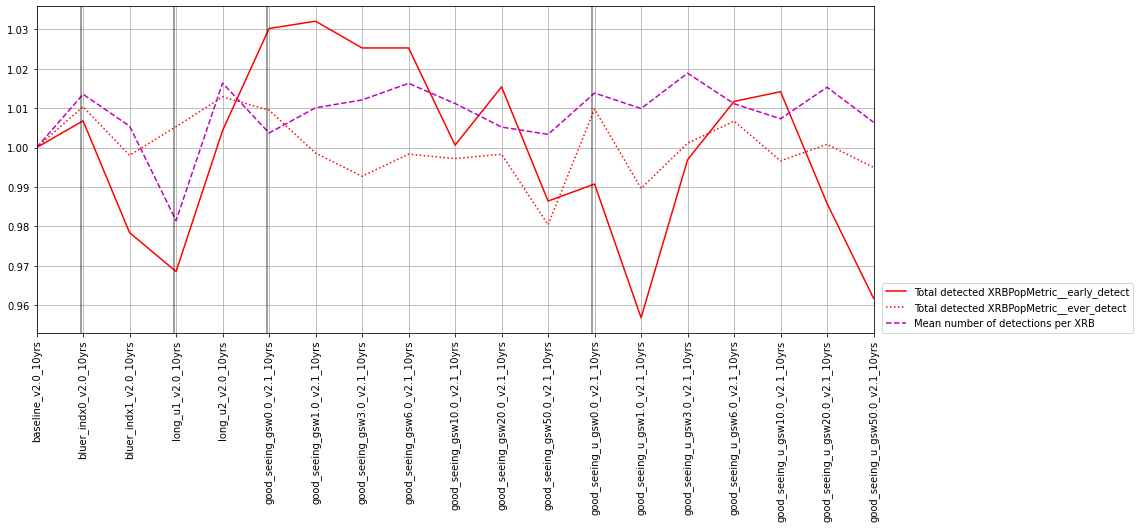

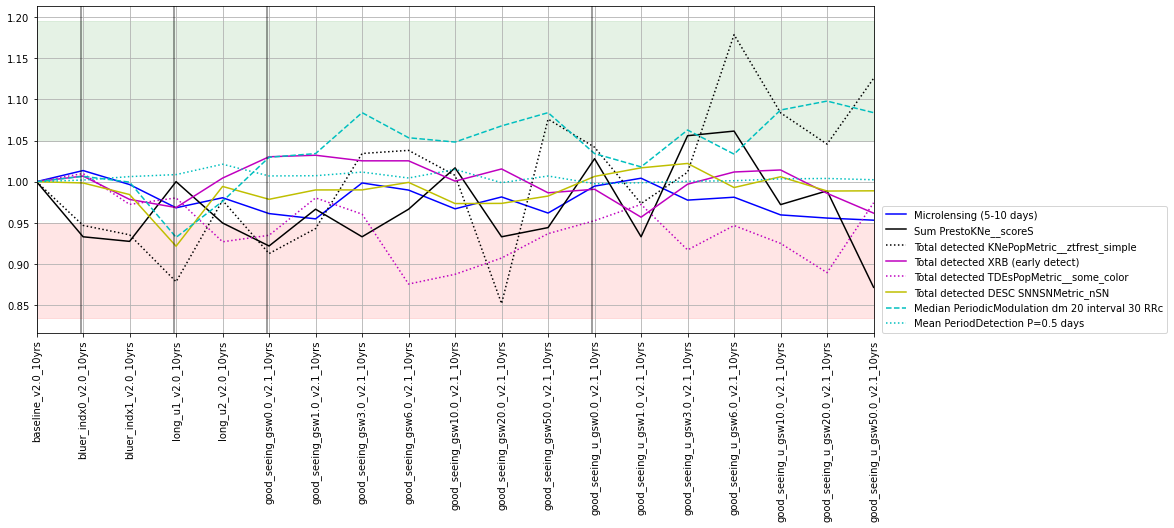

In [139]:
# Which metrics seem like the closest matches for our stated goals? 
# Primarily TVS fast transients - KNe, TDE, XRB

kk = [k for k in msets if k.startswith('TVS') and ('KNe' in k or 'Presto' in k or
                                                   'TDE' in k or 'XRB' in k or 'short' in k)]
for k in kk:

    # Plot two versions of the figures
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=metric_set.loc[k]['short_name'],
                                       metric_set=metric_set.loc[k],
                                      color_range=0.3)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)
        
for k in kk:
    
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    ylims = list(ax.get_ylim())
    if ylims[0] < 0.5:
        ylims[0] = 0.5
    if ylims[1] > 2:
        ylims[1] = 2
    ax.set_ylim(ylims)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

These don't seem to strongly support shifting more time into bluer bands. The KNe detections with `ztfrest_*` and the PrestoColorKNe metric are the ones prioritized by the community and show negative impacts from shifting into bluer bands. The TDE results show slight improvement, but not a large amount. 

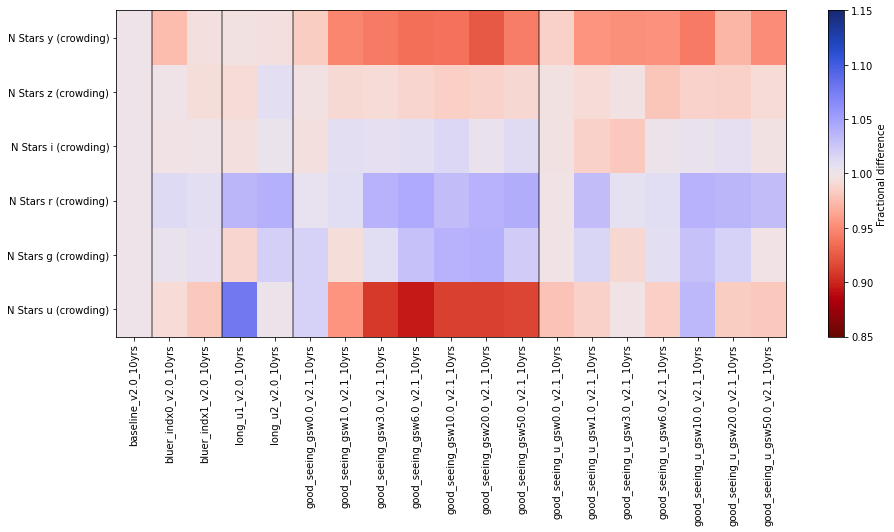

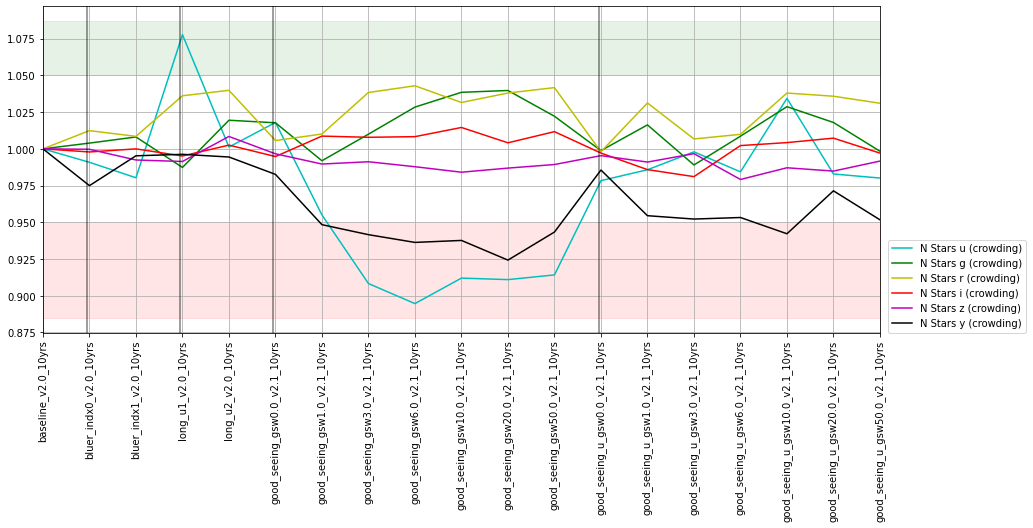

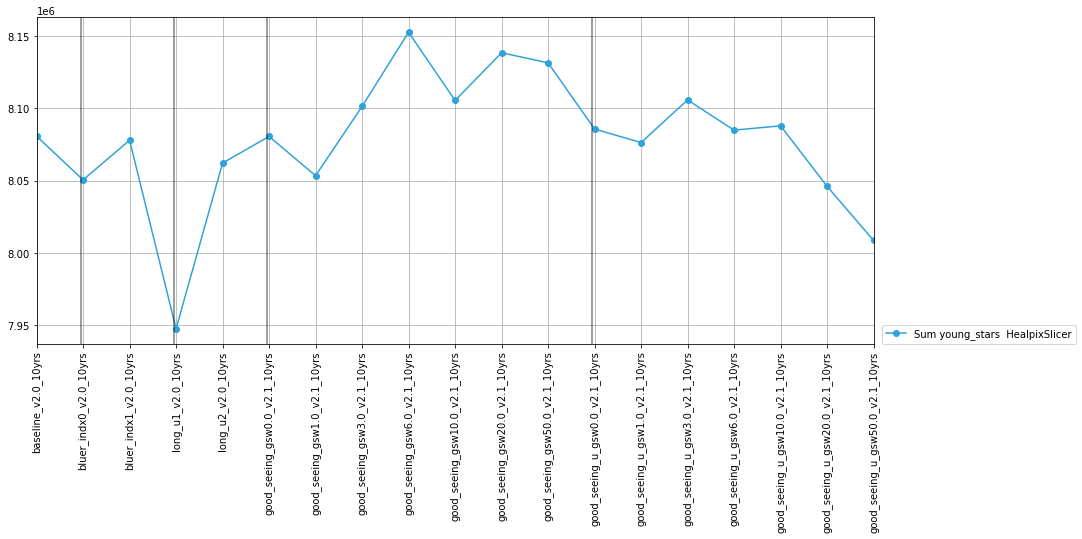

In [140]:
# Look for stellar populations
kk = [k for k in msets if k.startswith('Stars')]
for k in kk:

    # Plot two versions of the figures
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=metric_set.loc[k]['short_name'],
                                       metric_set=metric_set.loc[k],
                                      color_range=0.3)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)
        
for k in kk:
    
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    ylims = list(ax.get_ylim())
    if ylims[0] < 0.5:
        ylims[0] = 0.5
    if ylims[1] > 2:
        ylims[1] = 2
    ax.set_ylim(ylims)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)
        
# Add Young Stellar Objects metric (not normalized, just the values)
m = ['Sum young_stars  HealpixSlicer']
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, m],
                             horizontal_quantity='run',
                             vertical_quantity='value',
                              linestyles='-',
                             shade_fraction=None)
fig.set_figwidth(15)
lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

We don't have a metric aimed at turn-off stars specifically. The metrics here tend to vary with the overall coadded depth, although because we're not varying the filter balance in the bulge WFD region, the effect is likely to be muted. 

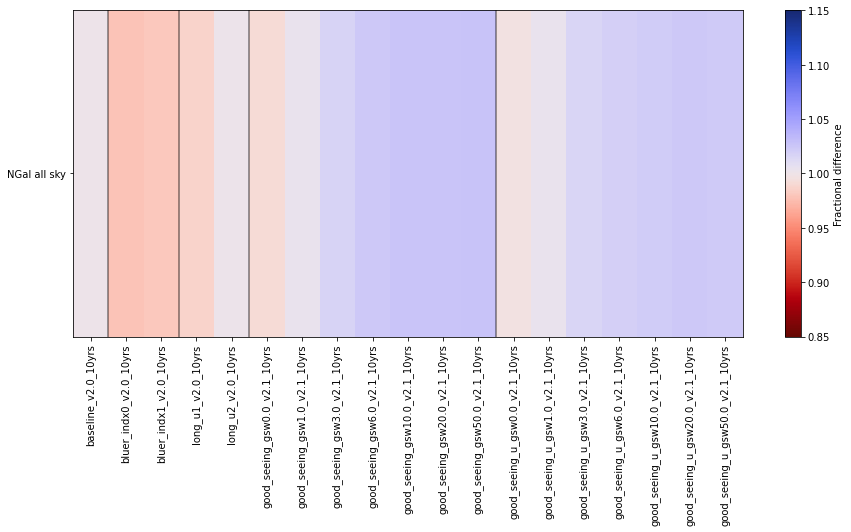

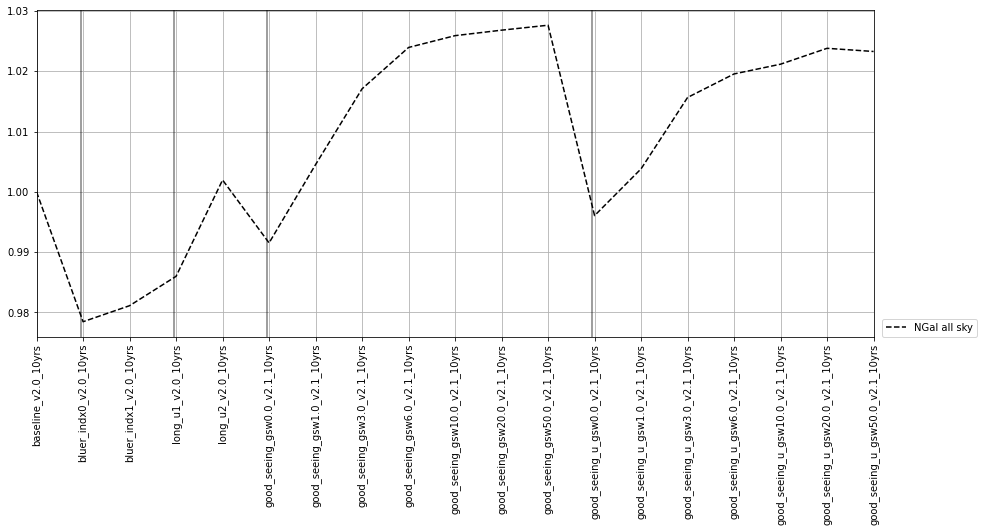

In [141]:
# Look at galaxies. (we only currently calculate galaxy counts in i band)
kk = [k for k in msets if k.startswith('galaxies')]
for k in kk:

    # Plot two versions of the figures
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=metric_set.loc[k]['short_name'],
                                       metric_set=metric_set.loc[k],
                                      color_range=0.3)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)
        
for k in kk:
    
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    ylims = list(ax.get_ylim())
    if ylims[0] < 0.5:
        ylims[0] = 0.5
    if ylims[1] > 2:
        ylims[1] = 2
    ax.set_ylim(ylims)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

This is also more or less as expected, scaling with the coadded depth, but since we're looking at the number of galaxies in i band, adding more bluer visits doesn't help.

Other metrics:

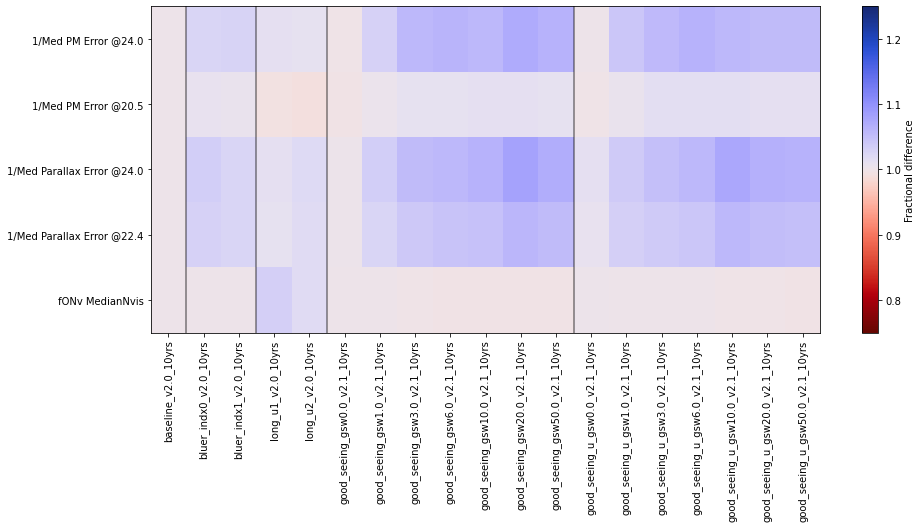

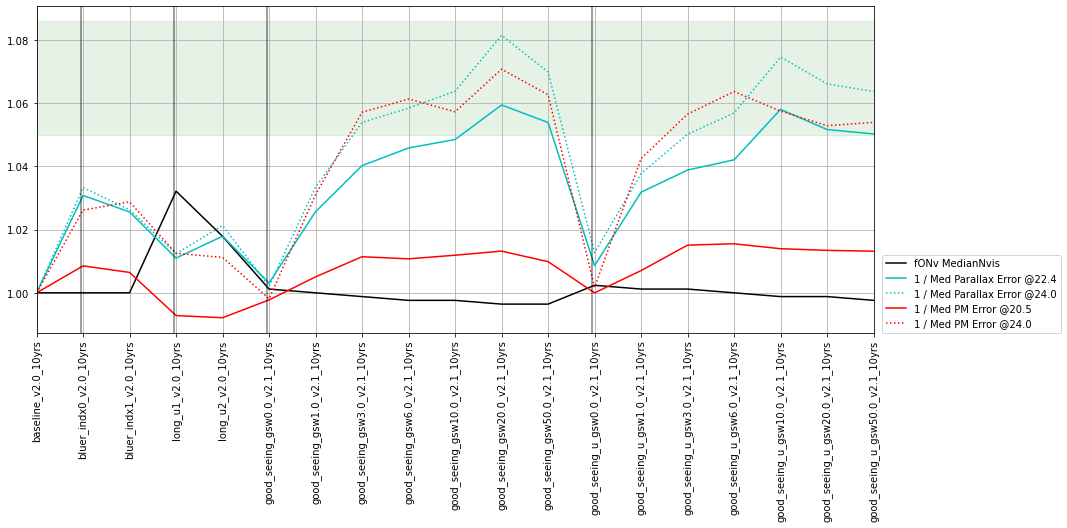

In [142]:
k = 'SRD'

# Plot two versions of the figures
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=metric_set.loc[k]['short_name'],
                                   metric_set=metric_set.loc[k],
                                  color_range=0.5)
fig.set_figwidth(15)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                              baseline_run=baseline_run,
                              metric_set=metric_set.loc[k],
                              metric_label_map=metric_set.loc[k]['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(15)
#ax.set_ylim(0.5, 1.5)
lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
for l in lines:
    ax.axvline(l-0.05, color='k', alpha=0.5)

**SRD** Slightly surprising improvements in parallax and faint proper motion, which I believe is driven by more g band measurements in the bluer balance runs and slightly deeper per-image depths in g band in the good seeing runs. The longer u band visits may be showing an improvement just due to having more visits overall (fONv Median Nvisits increases == more visits per pointing in the WFD).

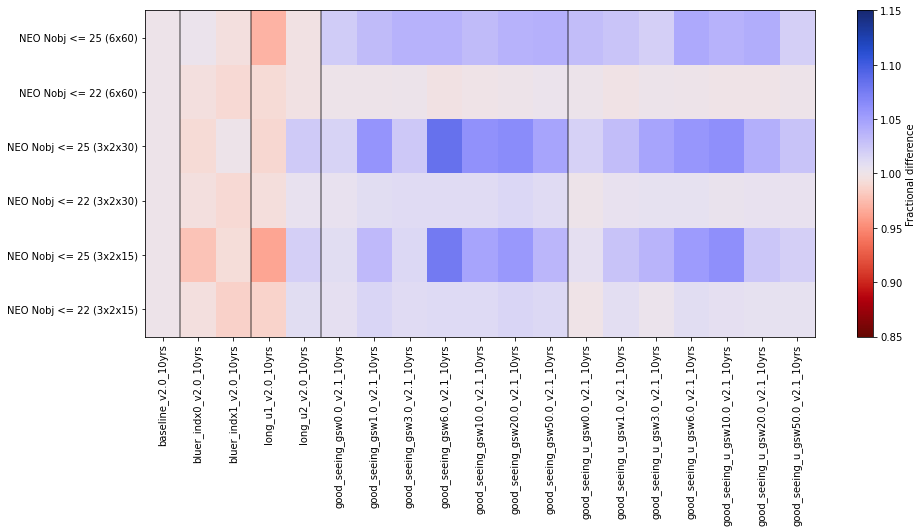

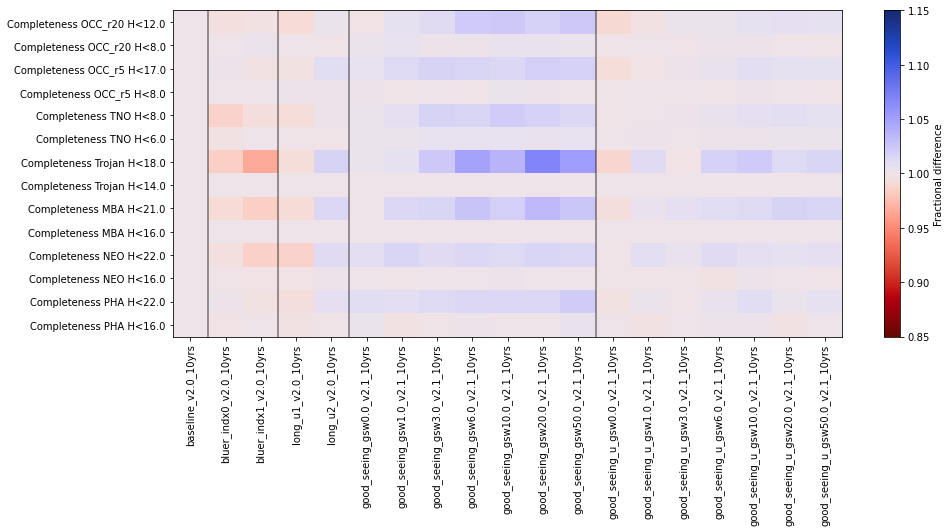

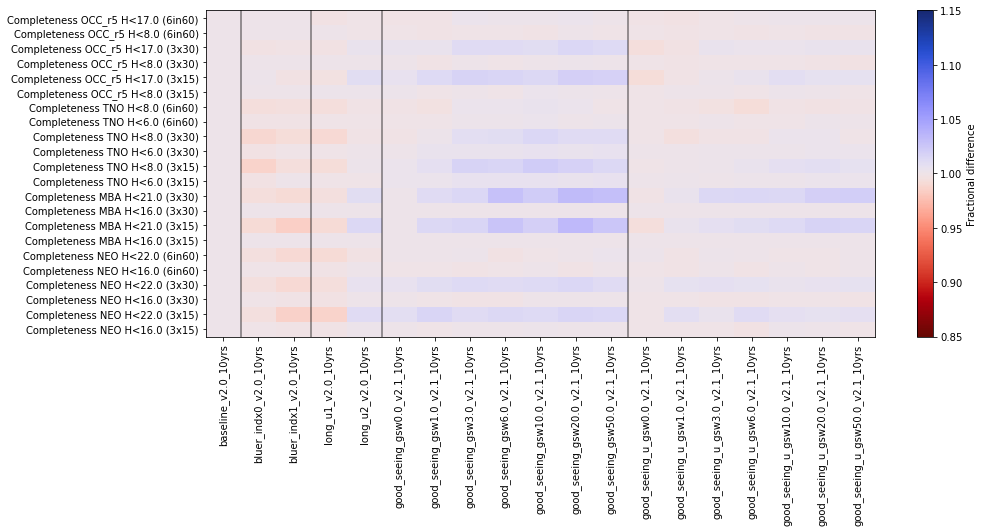

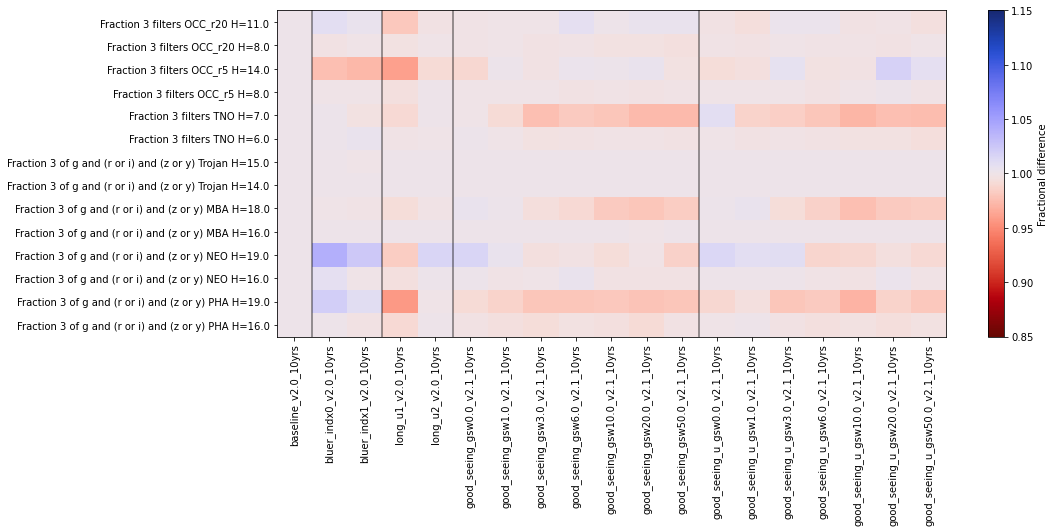

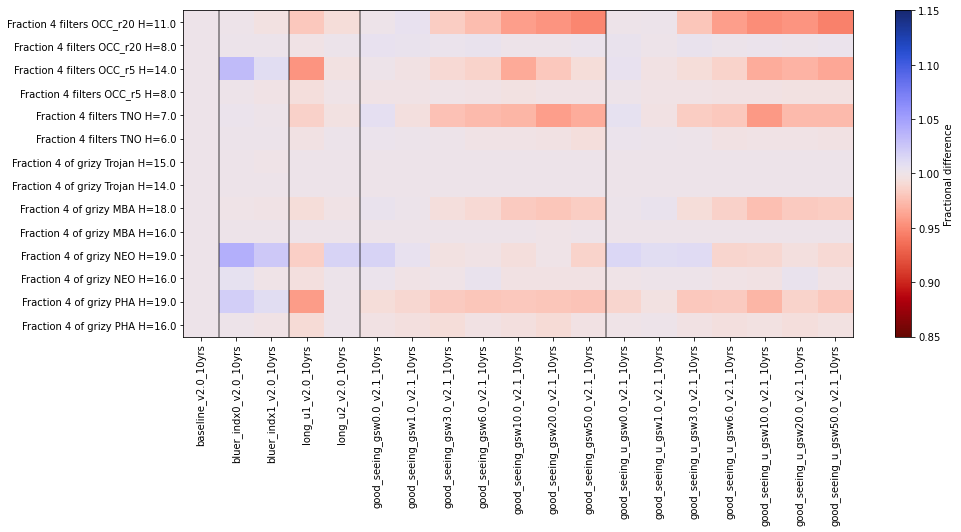

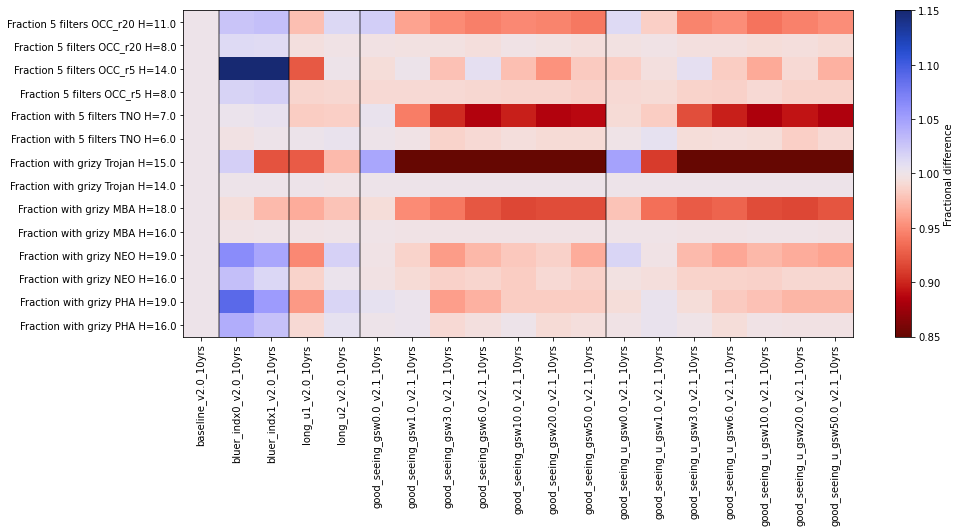

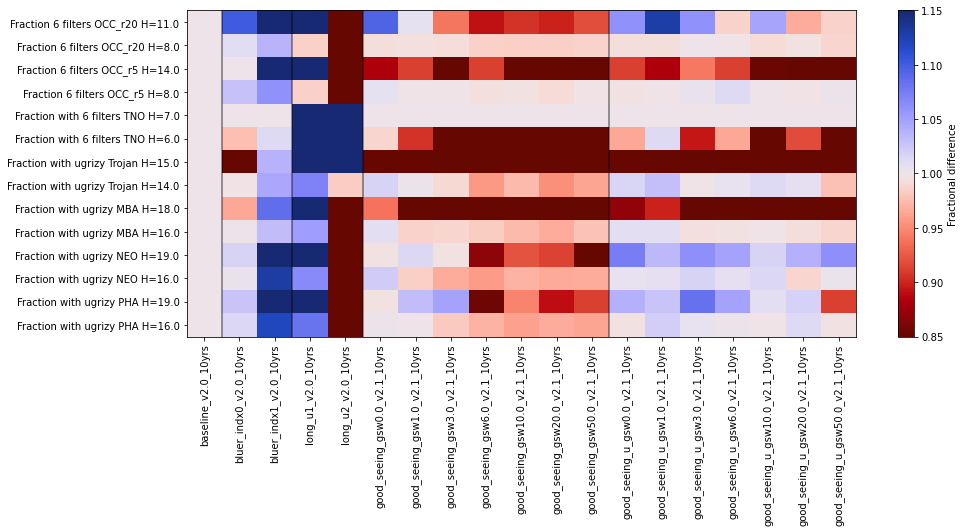

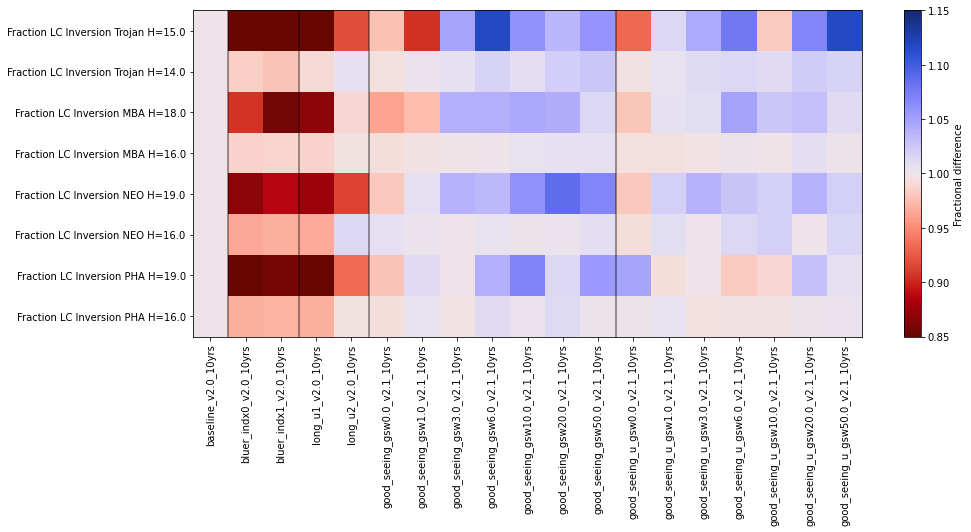

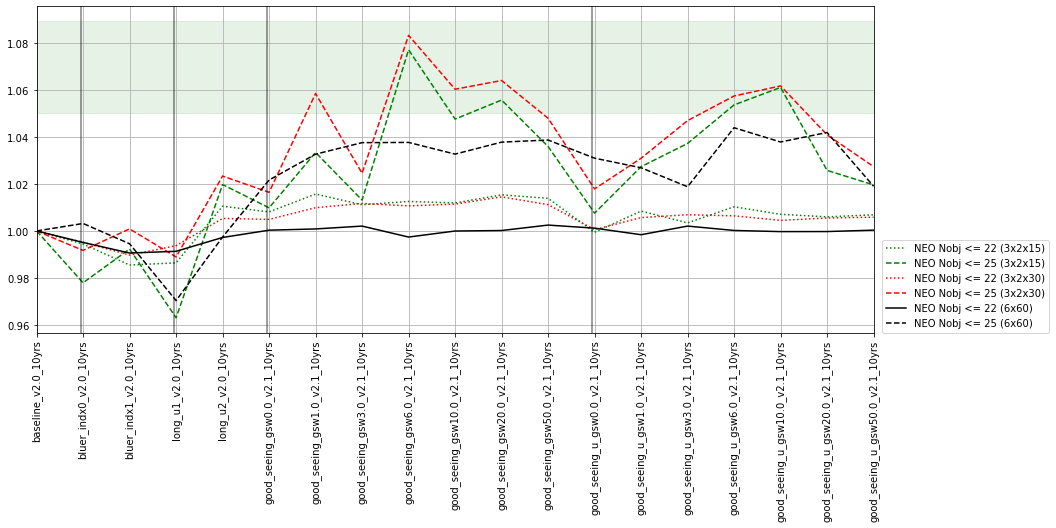

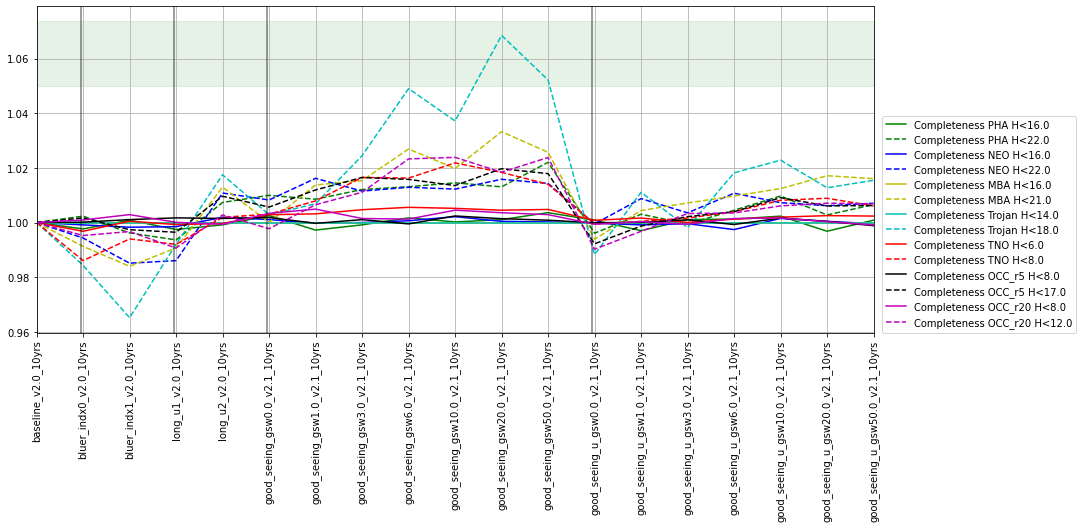

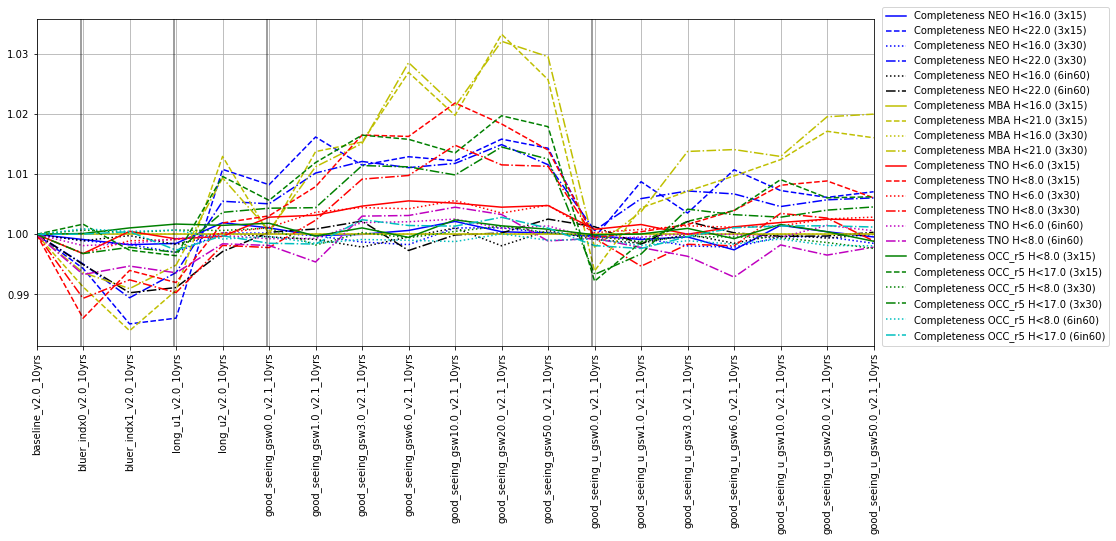

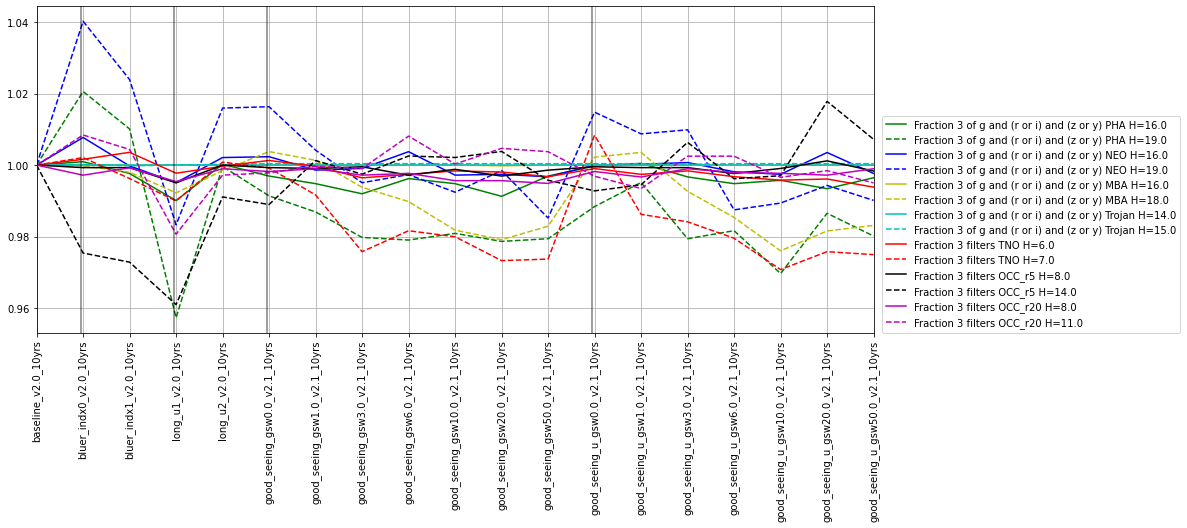

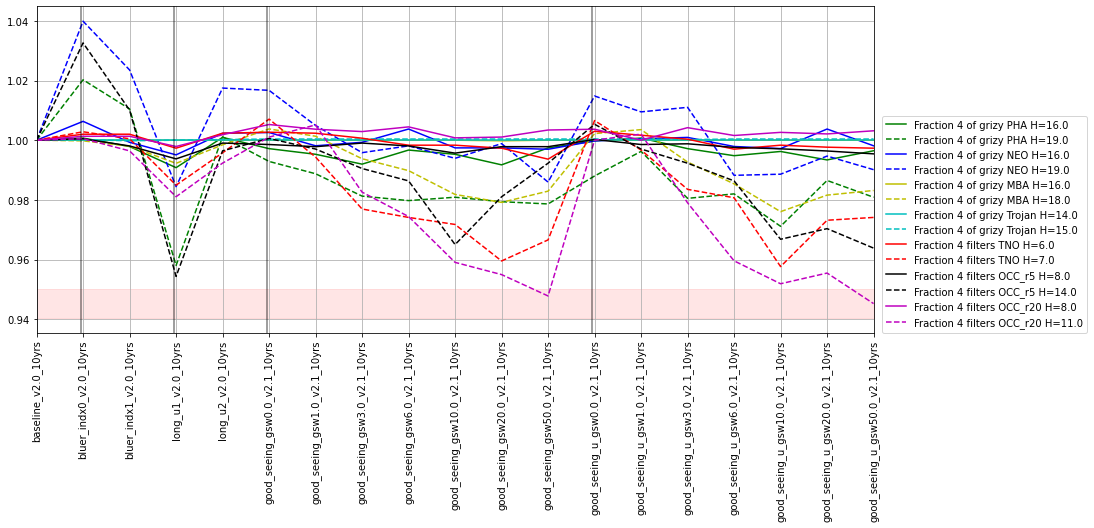

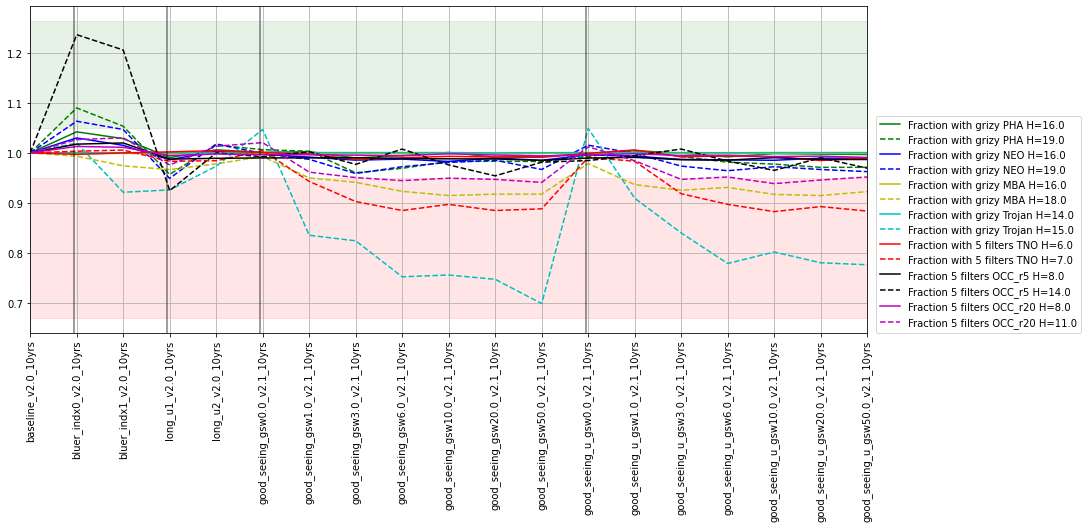

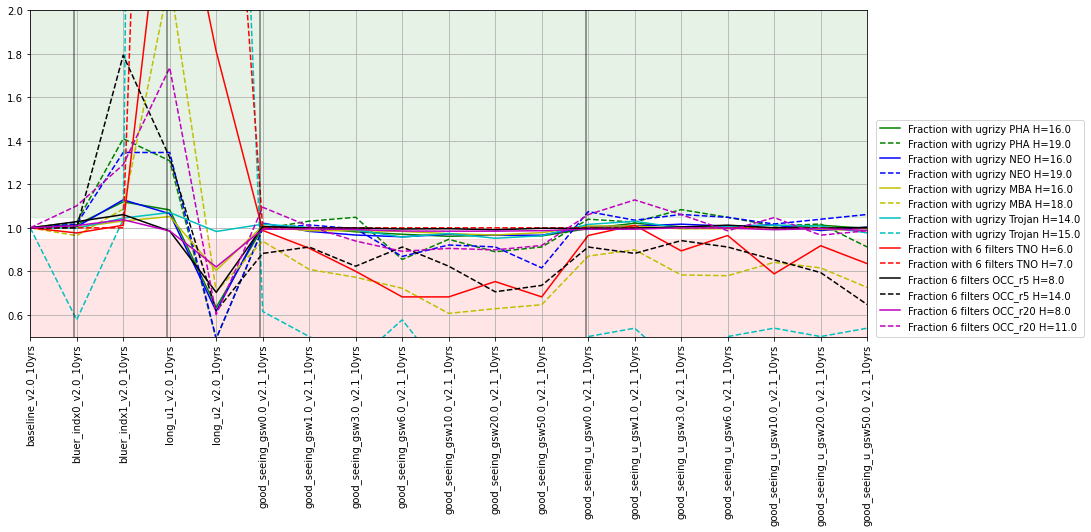

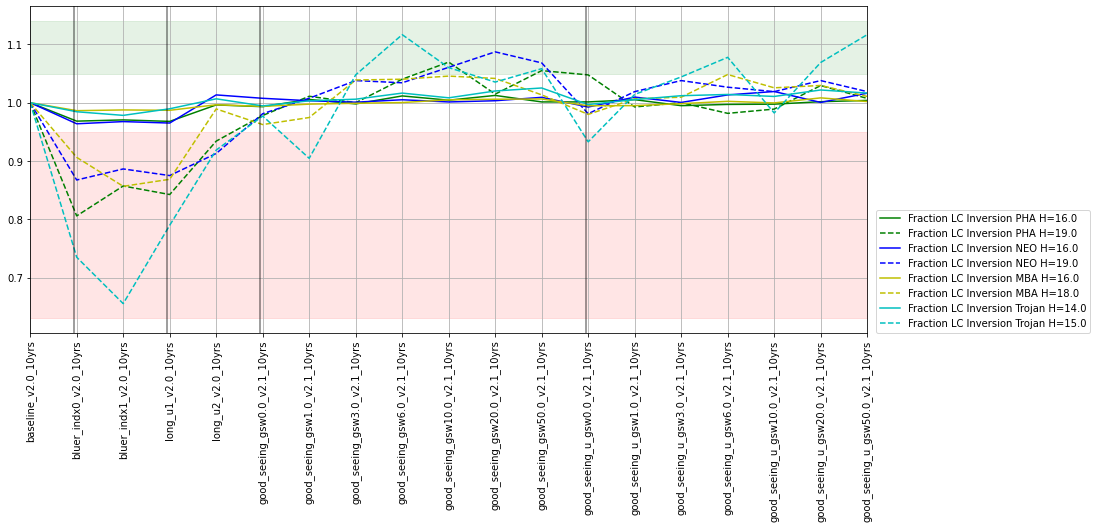

In [143]:
# Double check the SSO metrics
for k in [k for k in msets if k.startswith('SSO')]:

    # Plot two versions of the figures
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=metric_set.loc[k]['short_name'],
                                       metric_set=metric_set.loc[k],
                                      color_range=0.3)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)
        
for k in [k for k in msets if k.startswith('SSO')]:
    
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    ylims = list(ax.get_ylim())
    if ylims[0] < 0.5:
        ylims[0] = 0.5
    if ylims[1] > 2:
        ylims[1] = 2
    ax.set_ylim(ylims)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

**SSO** The top-level solar system metrics (surrounding discovery completeness and numbers of objects) are relatively neutral on the filter balance question, although more visits in g mean more opportunities for getting colors that include g band - particularly for the OCC_r5 population (Oort Cloud Comets with perihelia ~ 5 AU), but result in fewer faint objects that receive enough visits over a range of phases for successful lightcurve inversion (probably these objects needed visits in r and i bands, so fell just below threshold when those visits were shifted in g and/or u).   

The longer u band visits run where time is shifted into u band (long_u1) does poorly on most metrics; solar system objects are not bright in u band, and adding longer visits doesn't help enough to counteract the loss of time from other bandpasses.

The good seeing family is a mix; the number of NEOs detected increases (as would be expected when the typical per-image visit depth in gri increases) and completeness for all of the faint populations increases similarly, for the good-seeing runs where good seeing is acquired in gri. When u band is added to the good seeing bands, the improvement is on the order of half of 'gri' only. Moreover, the characterization metrics show decreases in these 'good seeing' runs, particularly when looking for colors in five or six bandpasses. The cause of this is likely that (as seen in the median single image depth plot above), u and y band image depths start to decrease as good seeing opportunities are diverted to gri bands. Solar system objects are not especially bright in u and y bands, so when looking for colors with these bandpasses, image depth becomes more critical. 

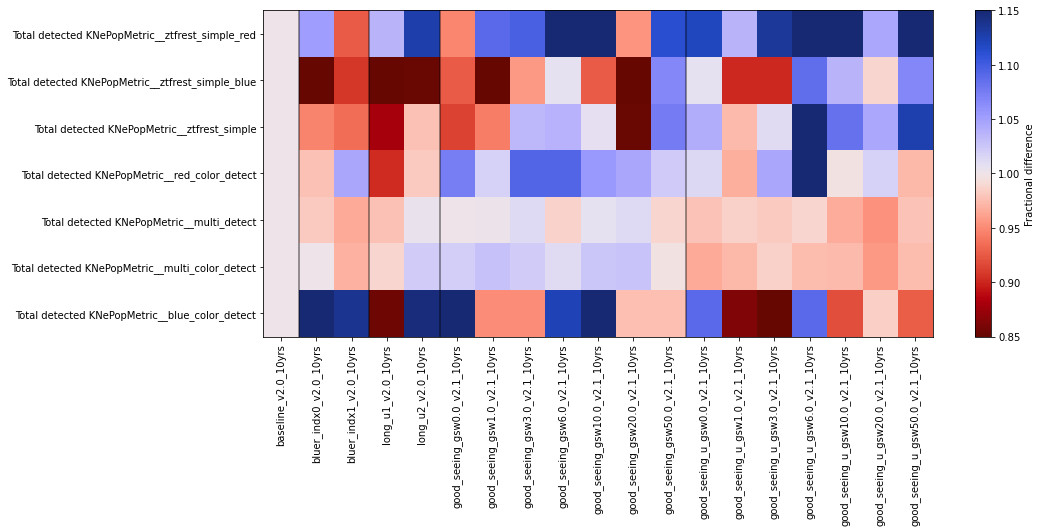

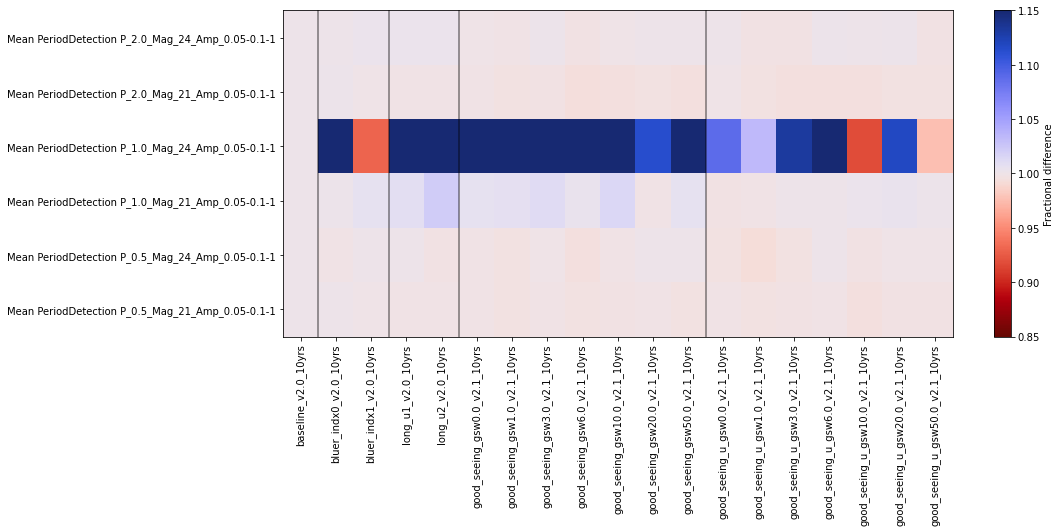

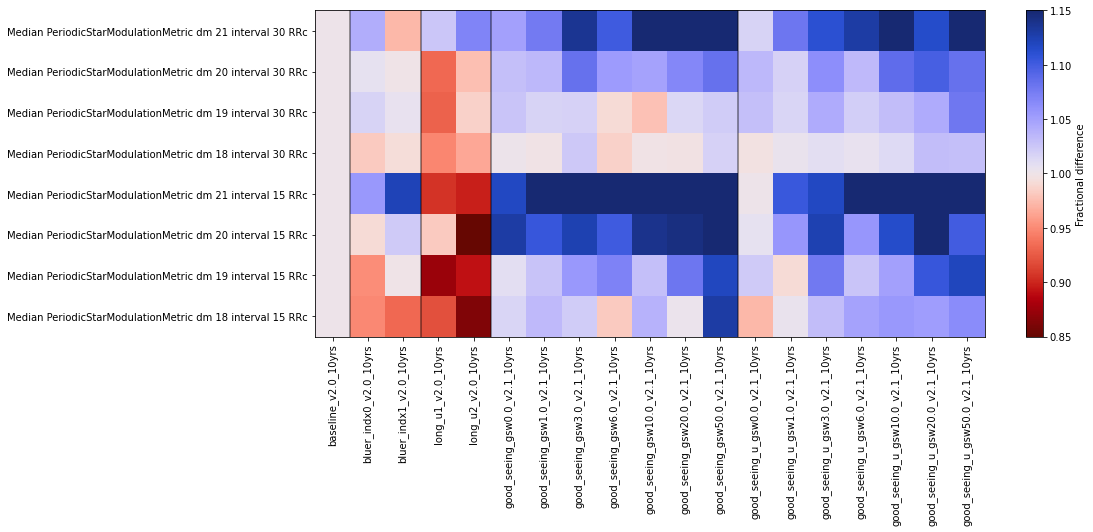

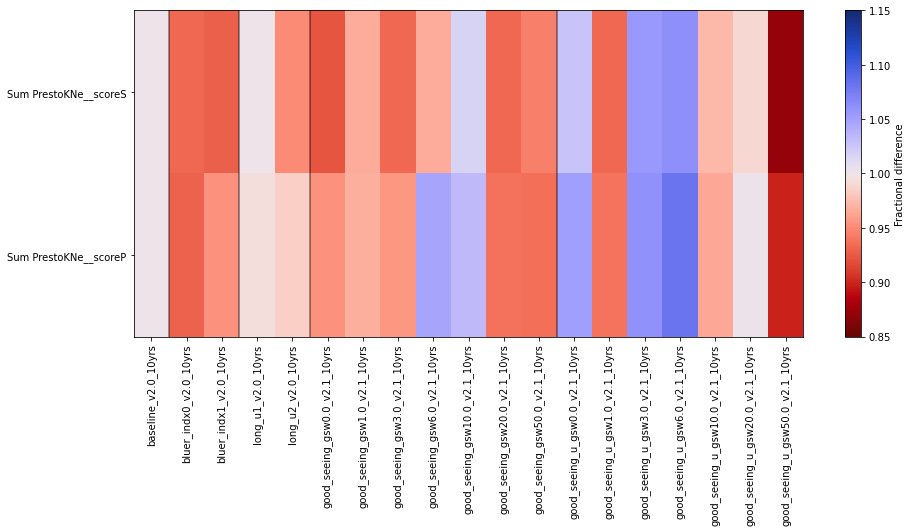

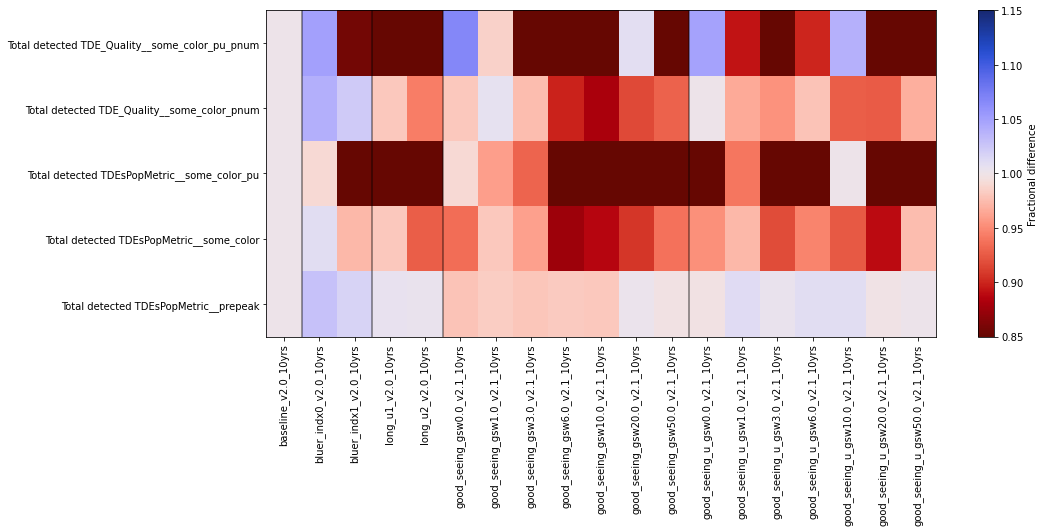

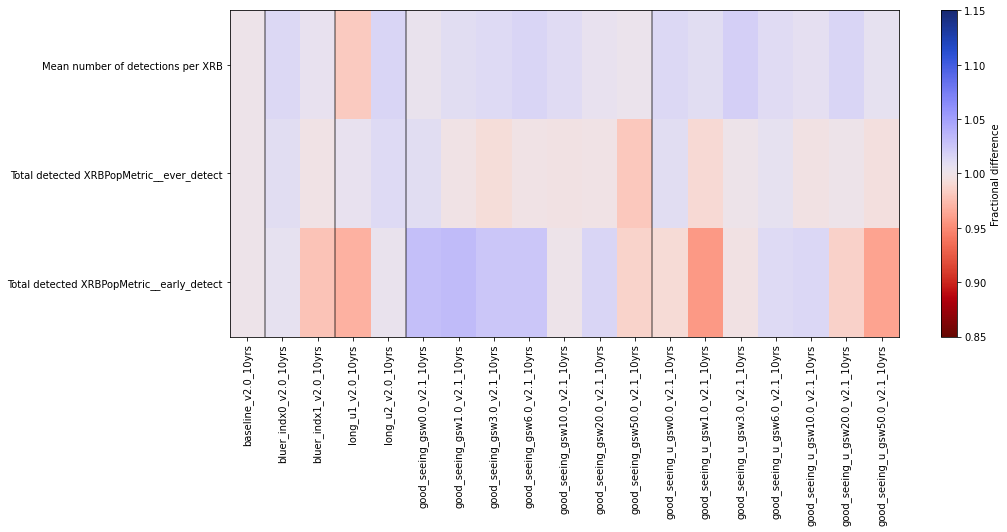

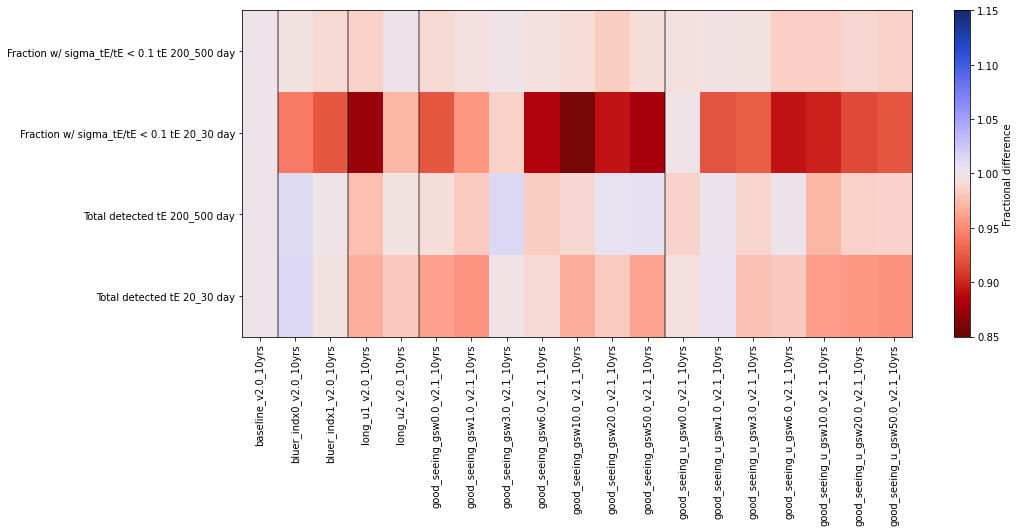

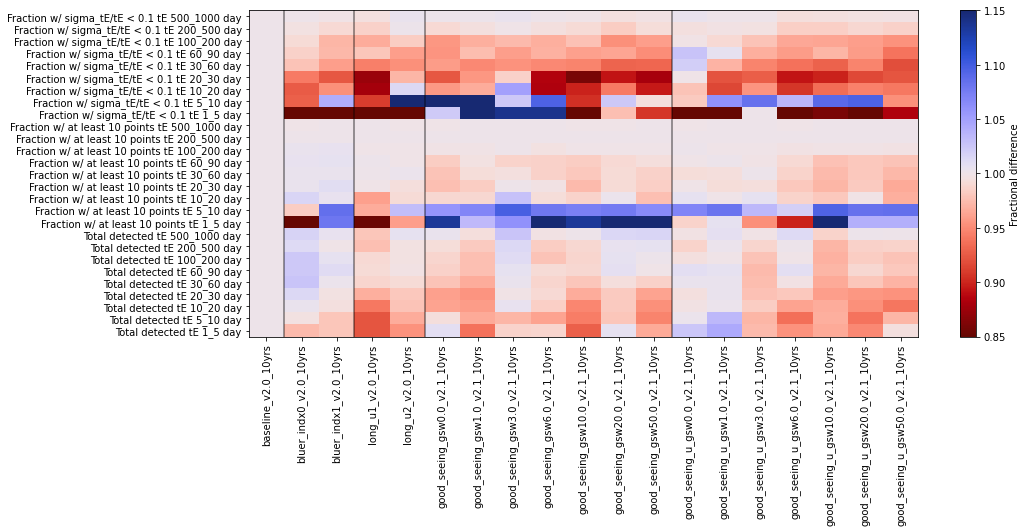

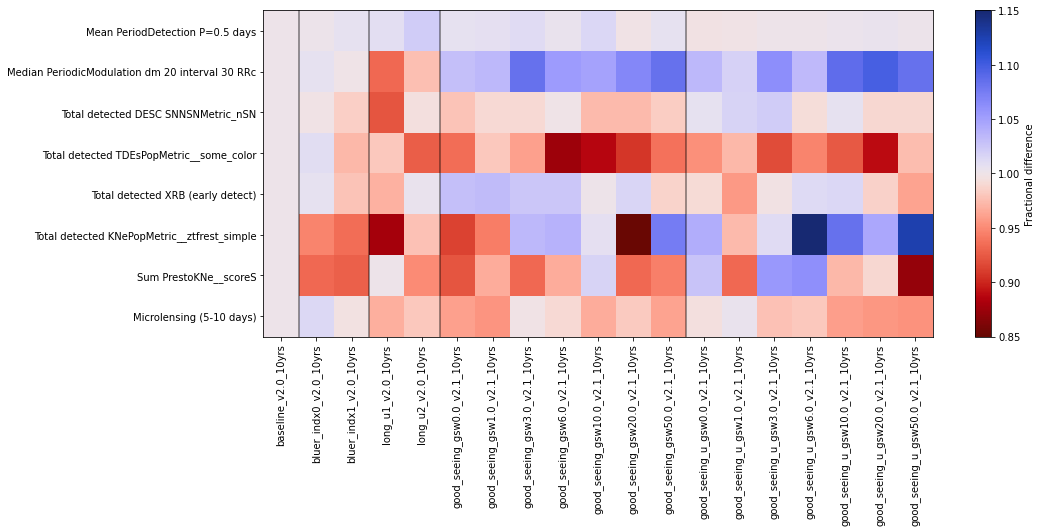

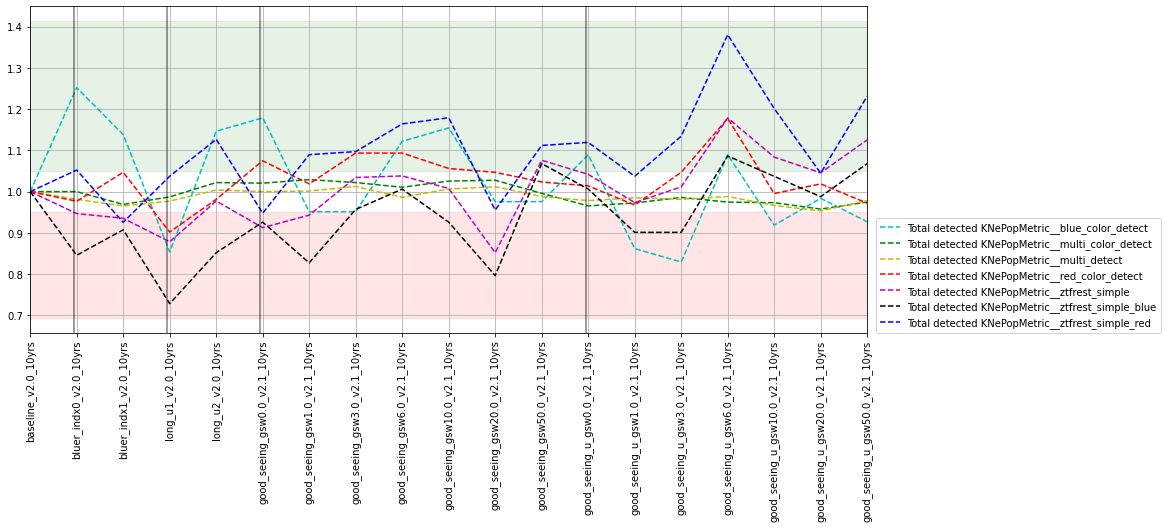

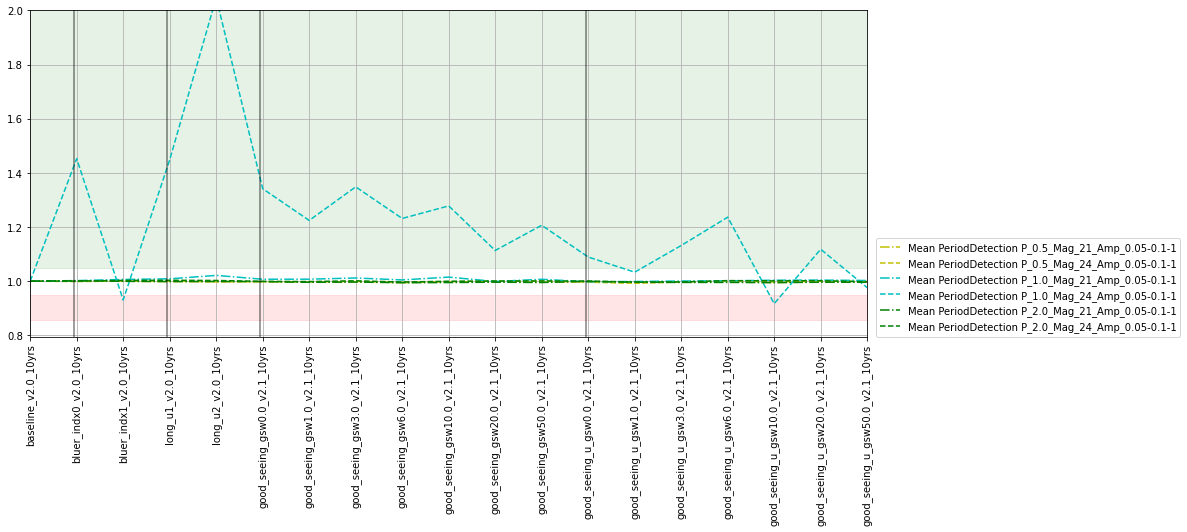

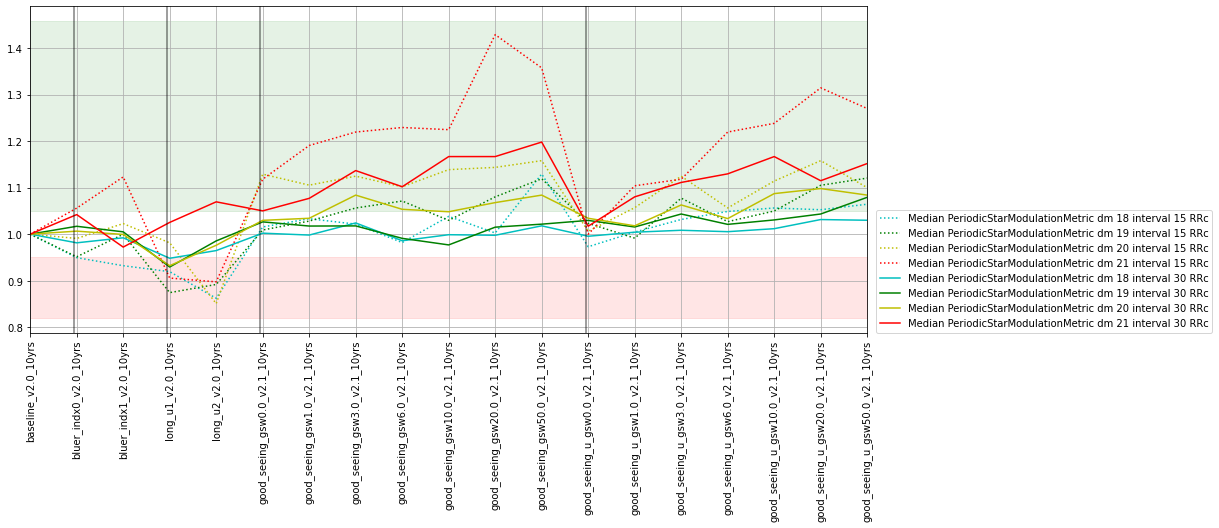

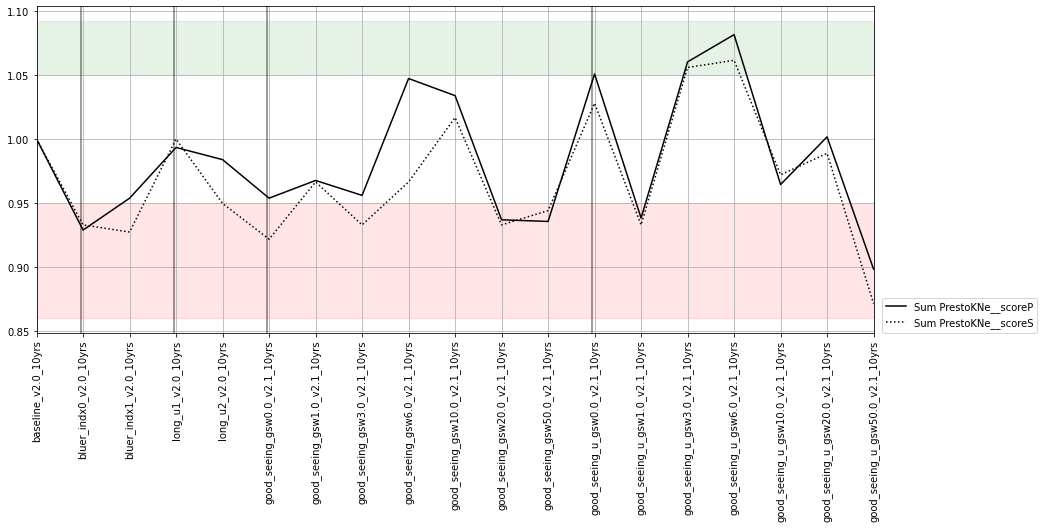

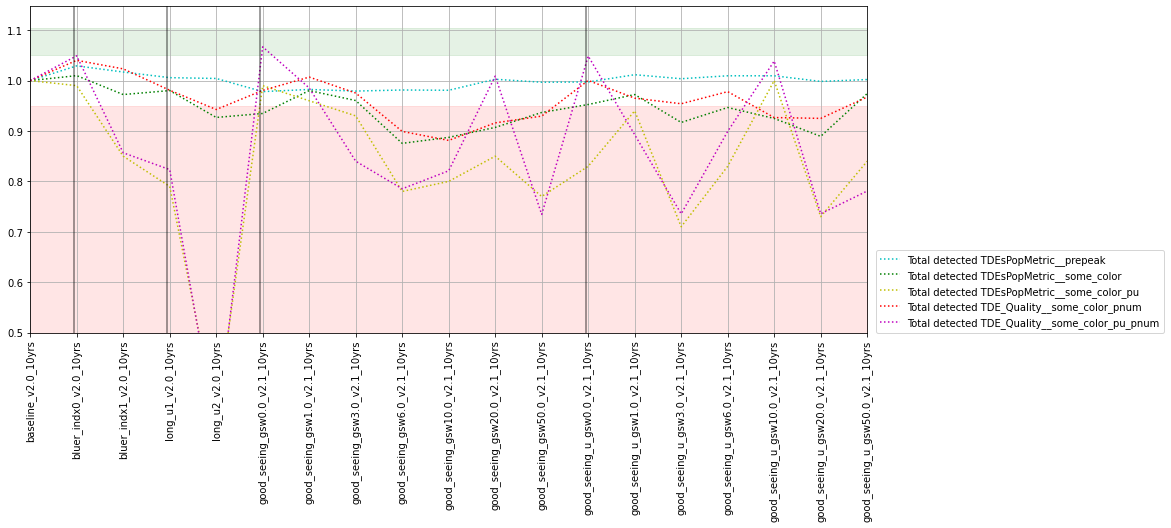

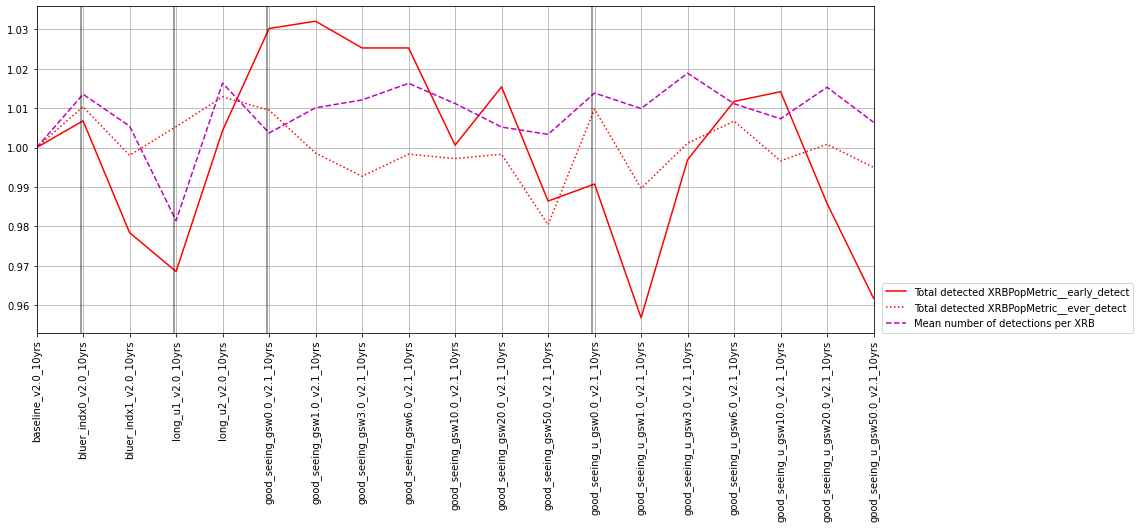

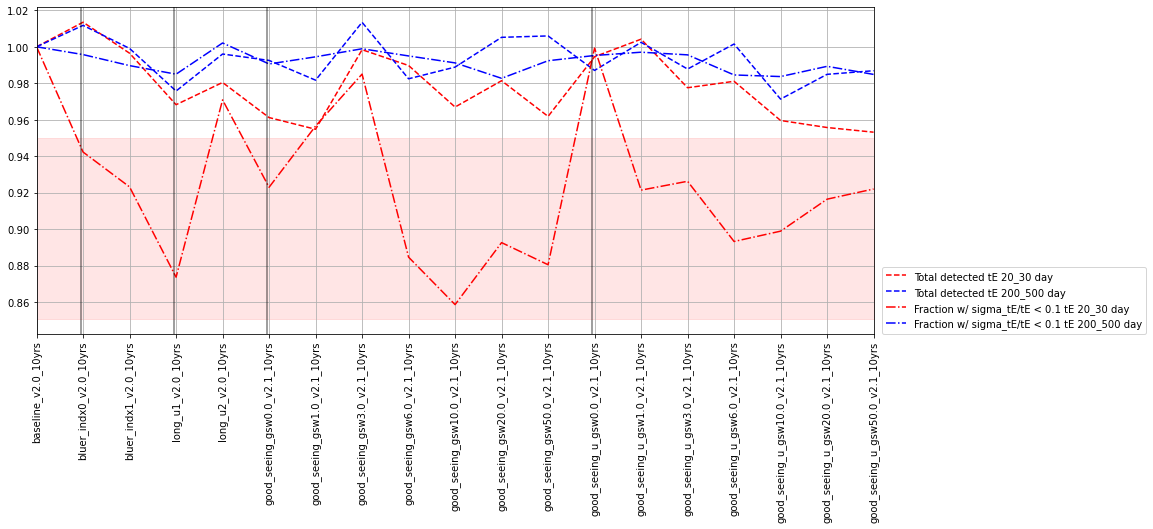

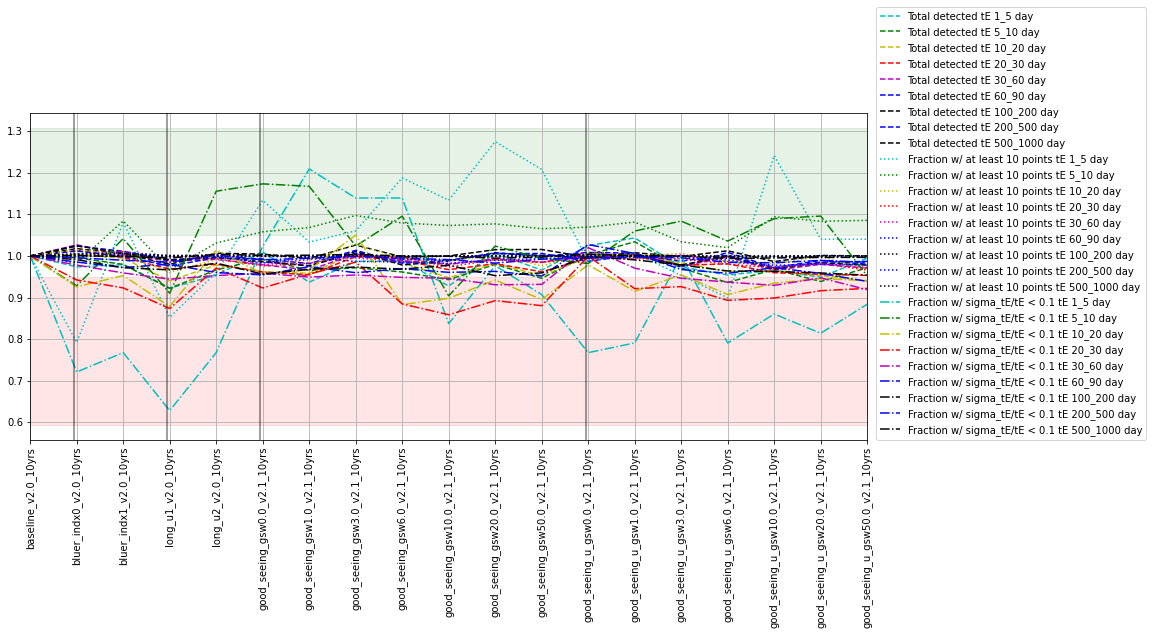

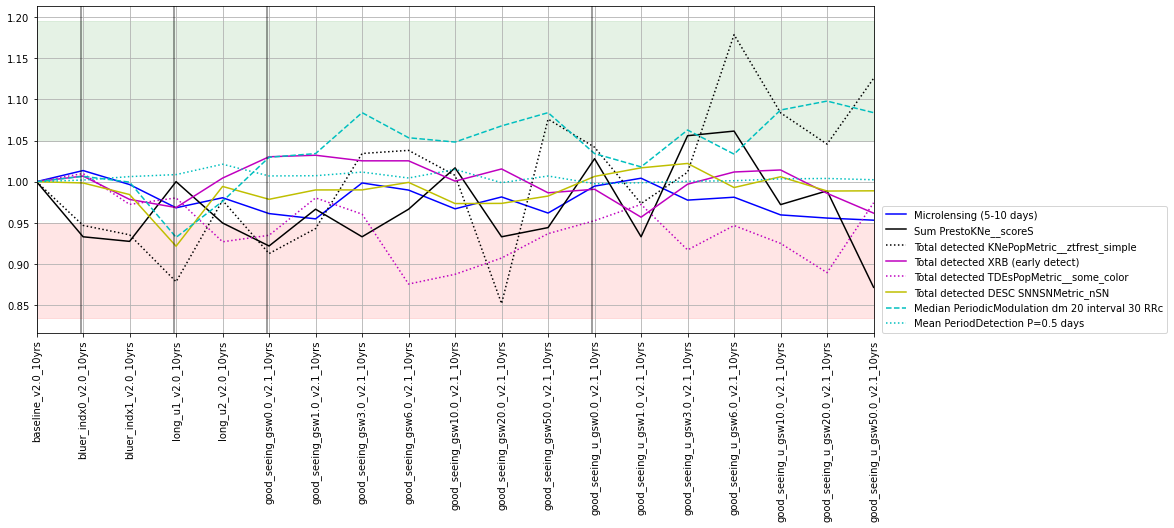

In [144]:
# Look at all TVS (repeats of some of the above)
kk = [k for k in msets if k.startswith('TVS')]
for k in kk:

    # Plot two versions of the figures
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=metric_set.loc[k]['short_name'],
                                       metric_set=metric_set.loc[k],
                                      color_range=0.3)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)
        
for k in kk:
    
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    ylims = list(ax.get_ylim())
    if ylims[0] < 0.5:
        ylims[0] = 0.5
    if ylims[1] > 2:
        ylims[1] = 2
    ax.set_ylim(ylims)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

As above, I don't believe this shows much preference for more bluer band visits. 

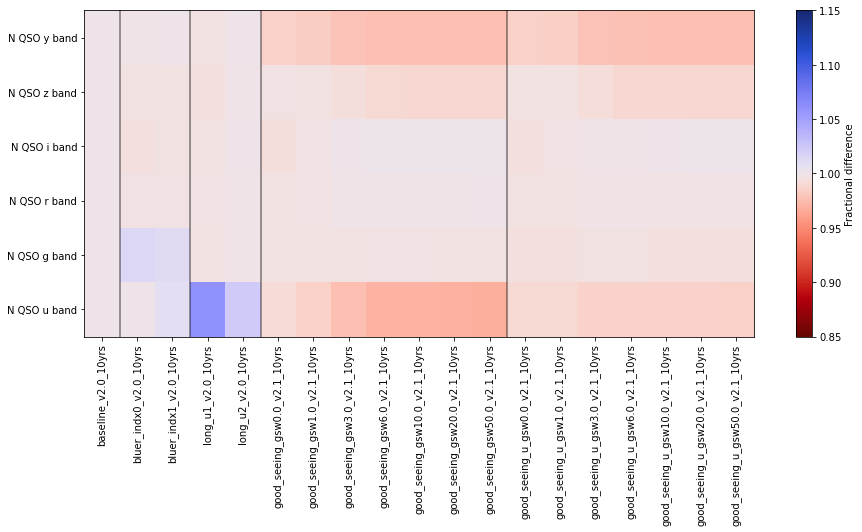

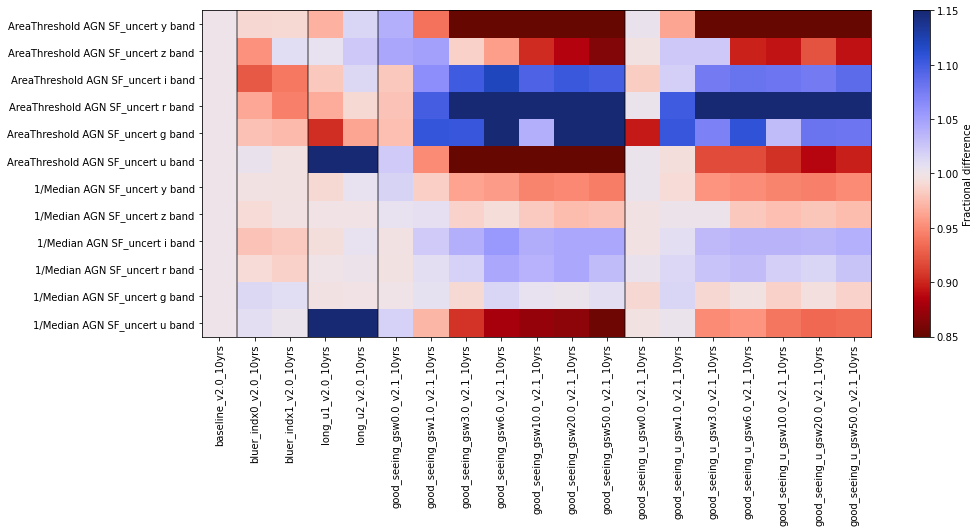

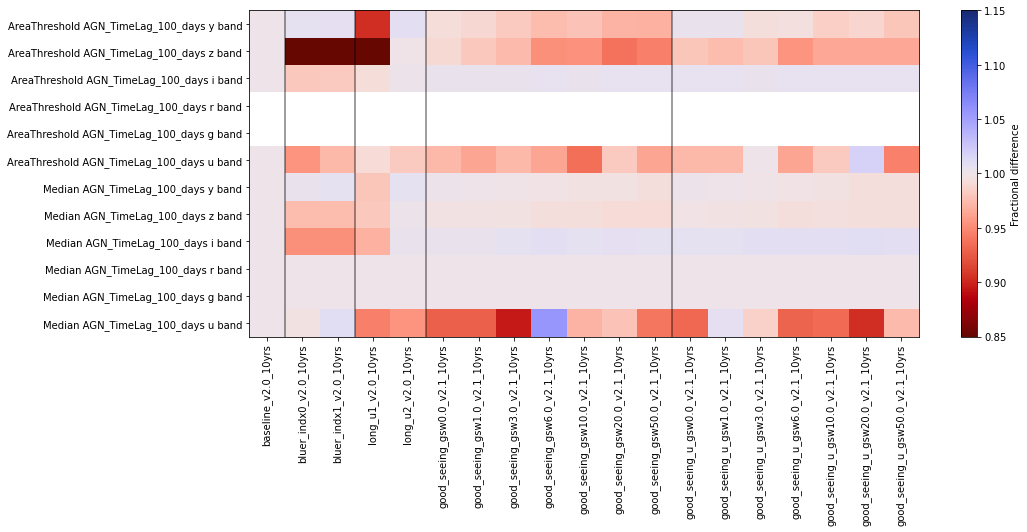

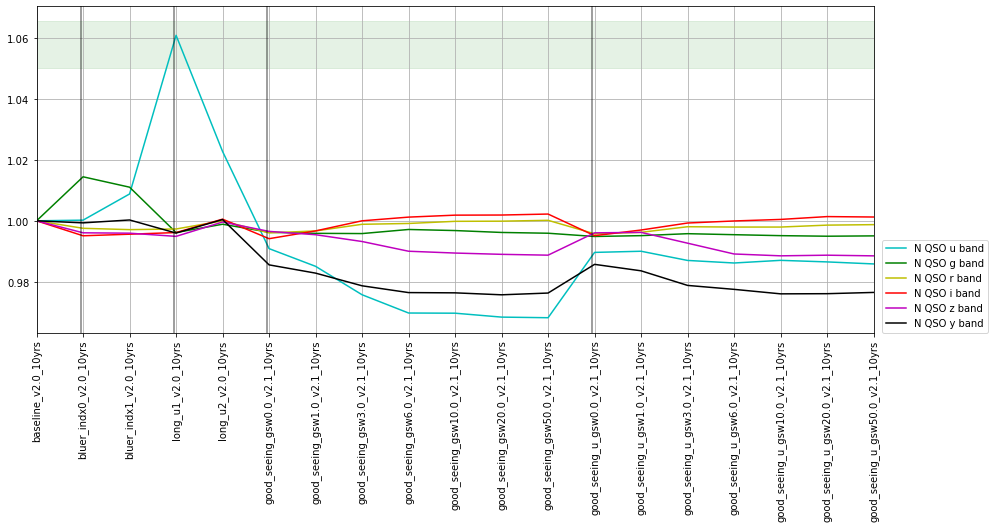

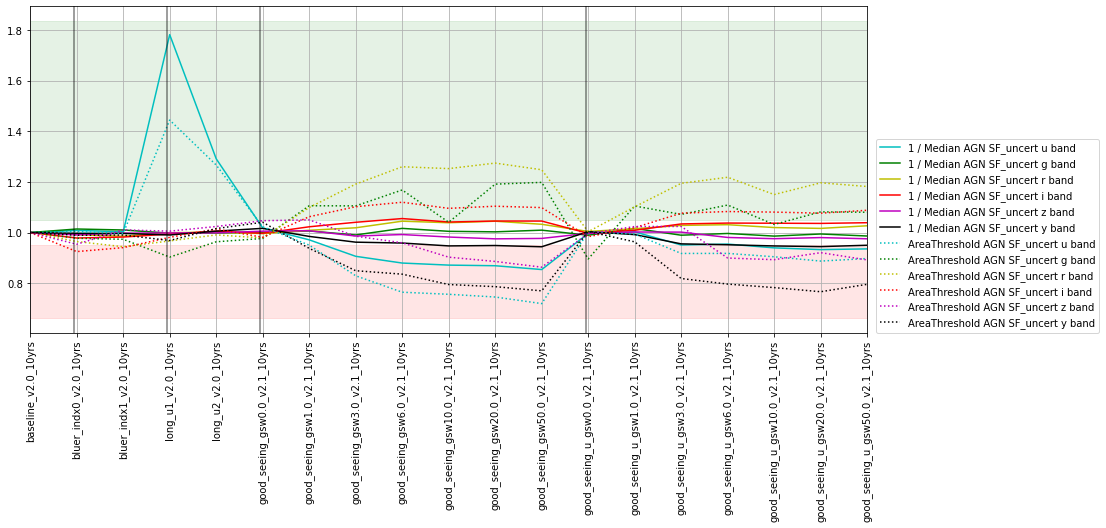

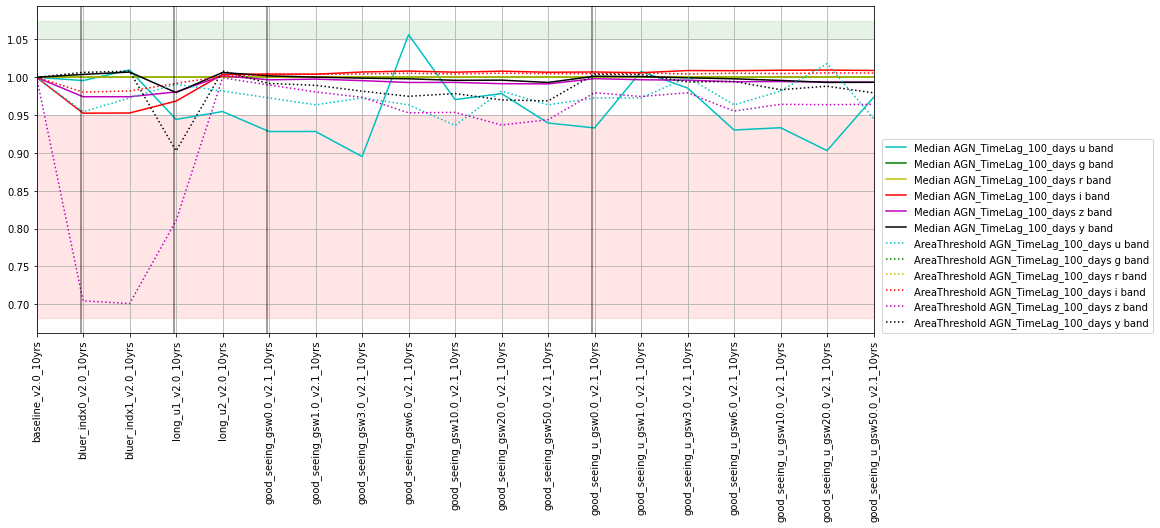

In [145]:
kk = [k for k in msets if k.startswith('AGN') and not k.endswith('DDF')]
for k in kk:

    # Plot two versions of the figures
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=metric_set.loc[k]['short_name'],
                                       metric_set=metric_set.loc[k],
                                      color_range=0.3)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)
        
for k in kk:
    
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    ylims = list(ax.get_ylim())
    if ylims[0] < 0.5:
        ylims[0] = 0.5
    if ylims[1] > 2:
        ylims[1] = 2
    ax.set_ylim(ylims)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

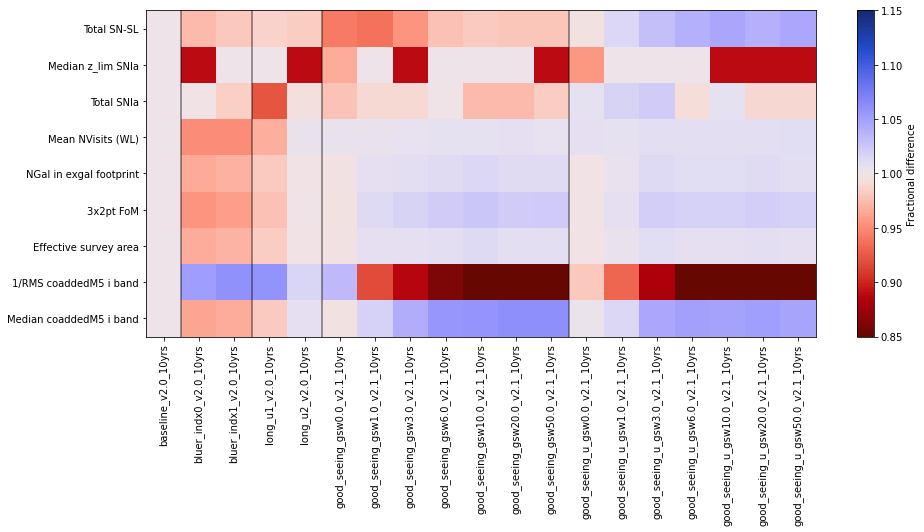

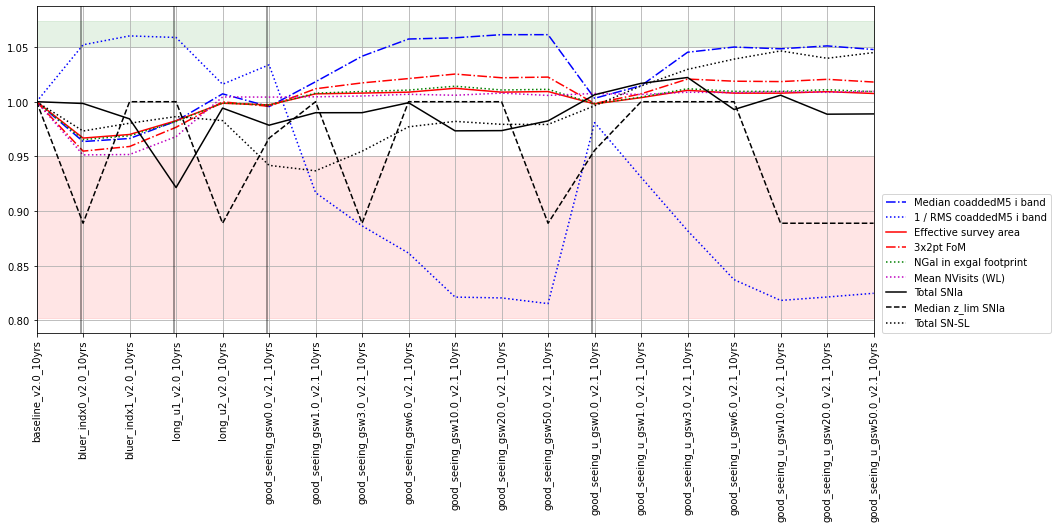

In [146]:
kk = [k for k in msets if k.startswith('DESC') and not k.endswith('DDF')]
for k in kk:

    # Plot two versions of the figures
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=metric_set.loc[k]['short_name'],
                                       metric_set=metric_set.loc[k],
                                      color_range=0.3)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)
        
for k in kk:
    
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    ylims = list(ax.get_ylim())
    if ylims[0] < 0.5:
        ylims[0] = 0.5
    if ylims[1] > 2:
        ylims[1] = 2
    ax.set_ylim(ylims)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

These metrics show negative impacts from shifting time into bluer bands, although not strongly negative (except perhaps in the median redshift limit for the SNIa sample). 
Generally DESC WFD metrics are related to i band depth and overall number of visits, as well as the few-day cadence (in SNIa). The results here seem consistent. 

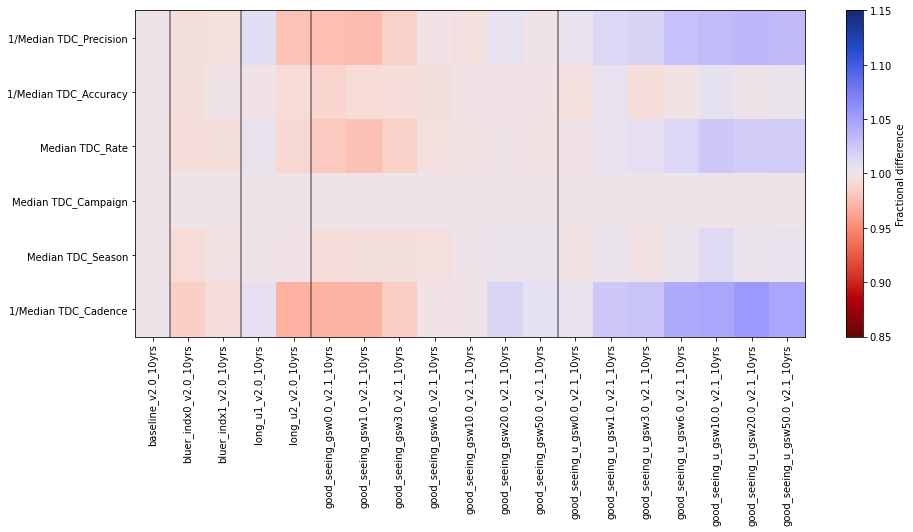

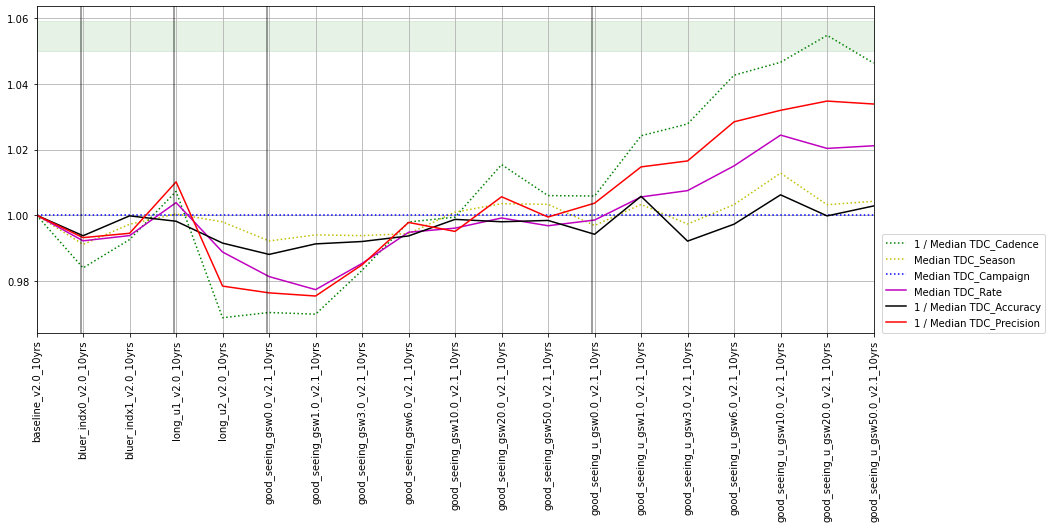

In [147]:
kk = [k for k in msets if k.startswith('SL') and not k.endswith('DDF')]
for k in kk:

    # Plot two versions of the figures
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=metric_set.loc[k]['short_name'],
                                       metric_set=metric_set.loc[k],
                                      color_range=0.3)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)
        
for k in kk:
    
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    ylims = list(ax.get_ylim())
    if ylims[0] < 0.5:
        ylims[0] = 0.5
    if ylims[1] > 2:
        ylims[1] = 2
    ax.set_ylim(ylims)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

The Strong lensing TDC metric is not strongly tied to the filters in use, although does have some desire for deeper images. The results here show little impact from the filter distribution. 
The increases in the metric in the 'good seeing u' series is interesting, and seems to be driven by a reduction in the mean cadence rate. (I'm talking to the SL group about their metric though, and the mean may be too simple; this is interesting but not conclusive). 

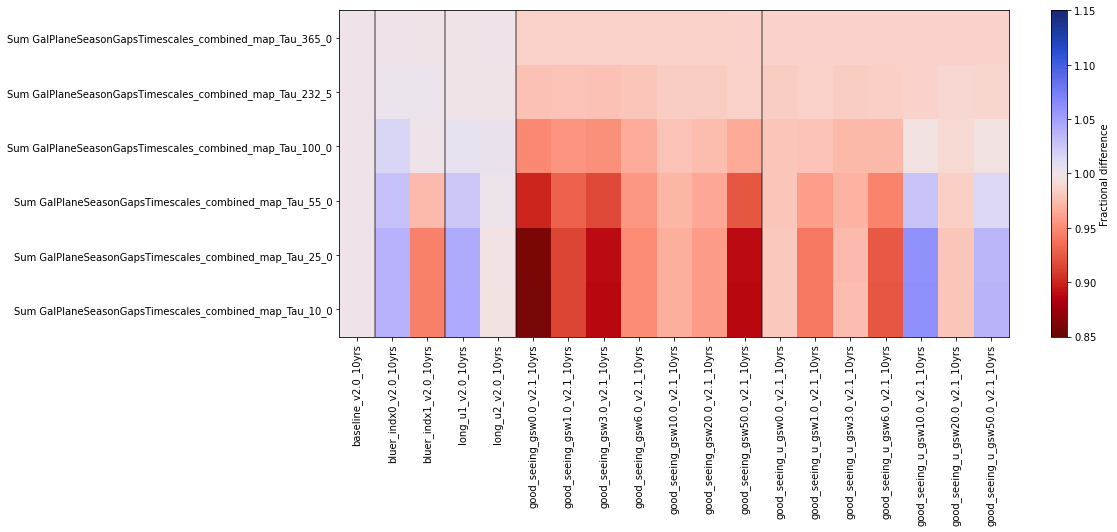

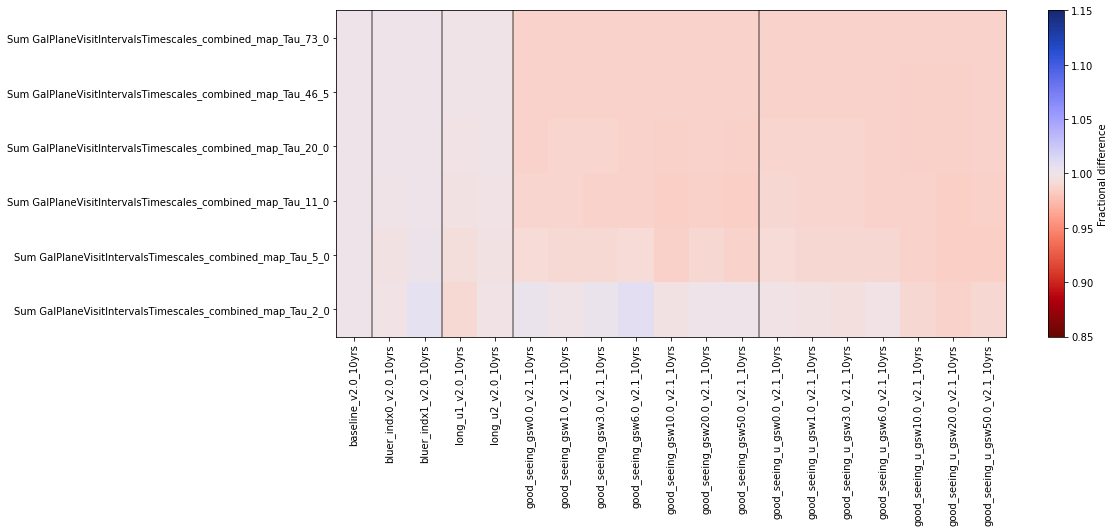

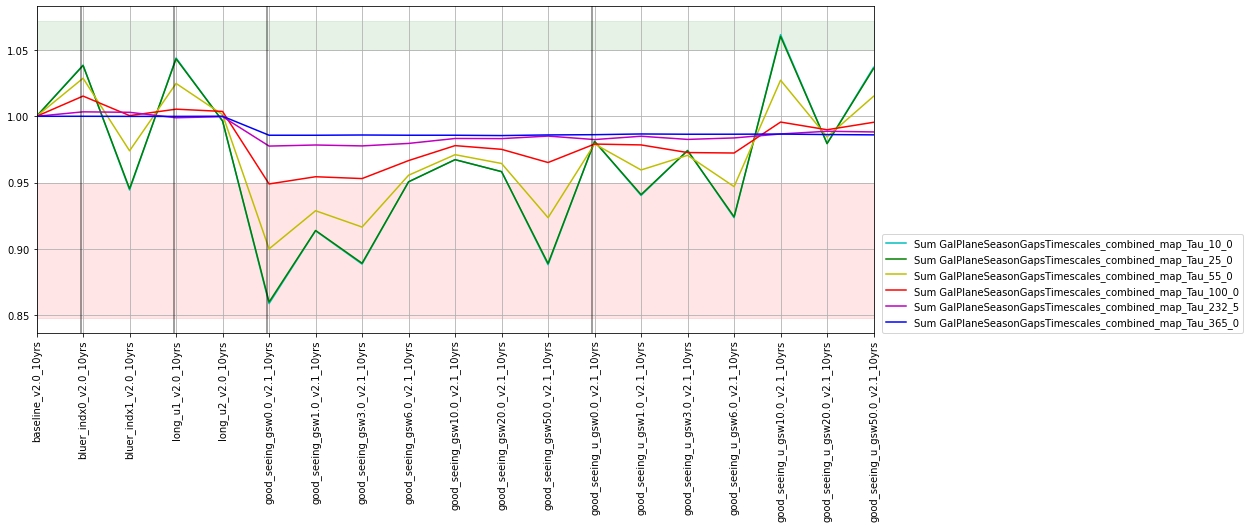

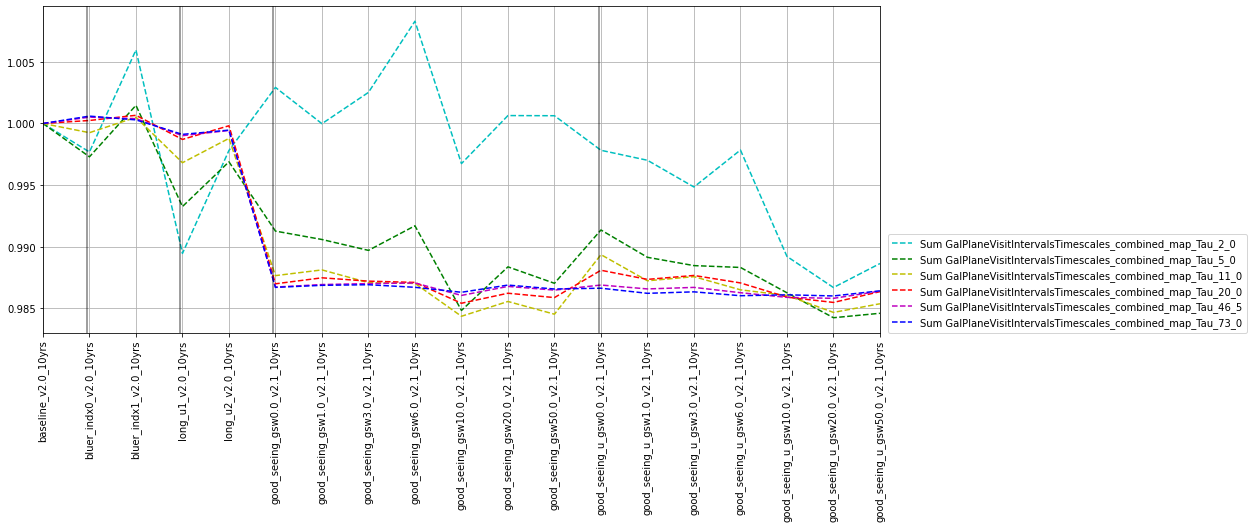

In [148]:
kk = [k for k in msets if k.startswith('GP ') and not k.endswith('DDF')]
for k in kk:

    # Plot two versions of the figures
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=metric_set.loc[k]['short_name'],
                                       metric_set=metric_set.loc[k],
                                      color_range=0.3)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)
        
for k in kk:
    
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    ylims = list(ax.get_ylim())
    if ylims[0] < 0.5:
        ylims[0] = 0.5
    if ylims[1] > 2:
        ylims[1] = 2
    ax.set_ylim(ylims)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

The VisitIntervals and SeasonGaps galactic plane metrics focus on the timing of visits in any filter, so I wasn't surprised to see that the filter balance didn't influence them much. The SeasonGaps is influenced more - I think in general, this metric is more vulerable to outlier visits (i.e. a single visit much later than typical will make a season 'good' versus under-threshold, so if there are perturbations which change the season length a bit, the seasonGaps results can change quite a bit). 
I was surprised though to see the negative impact from the good seeing simulations. This is likely due to this outlier / change in the season length effect, and could use more feedback from the SLVMW group to understand if these are serious effects (but can be discussed further in the context of the good seeing simulations). 

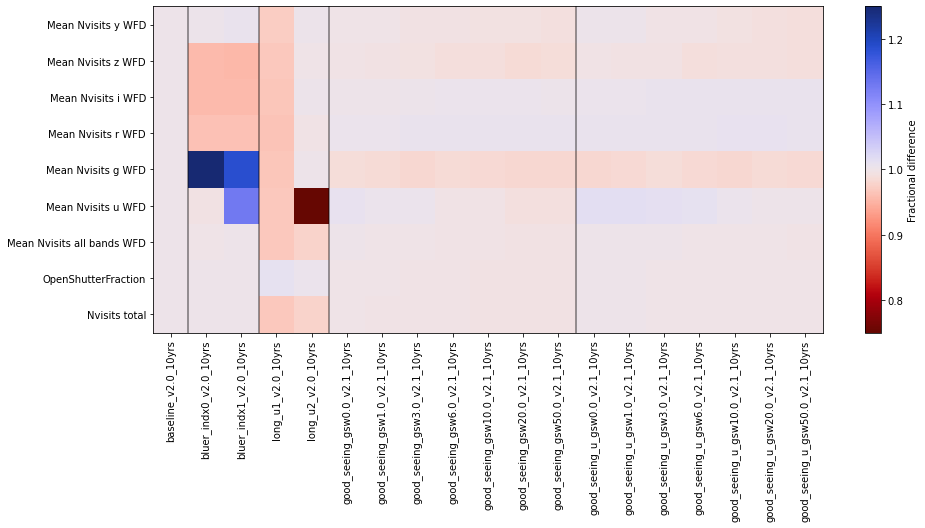

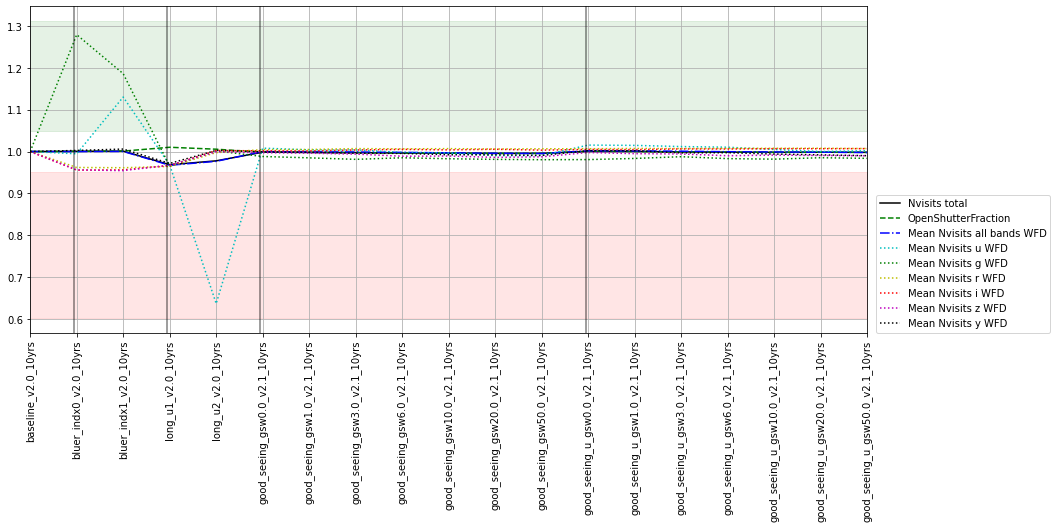

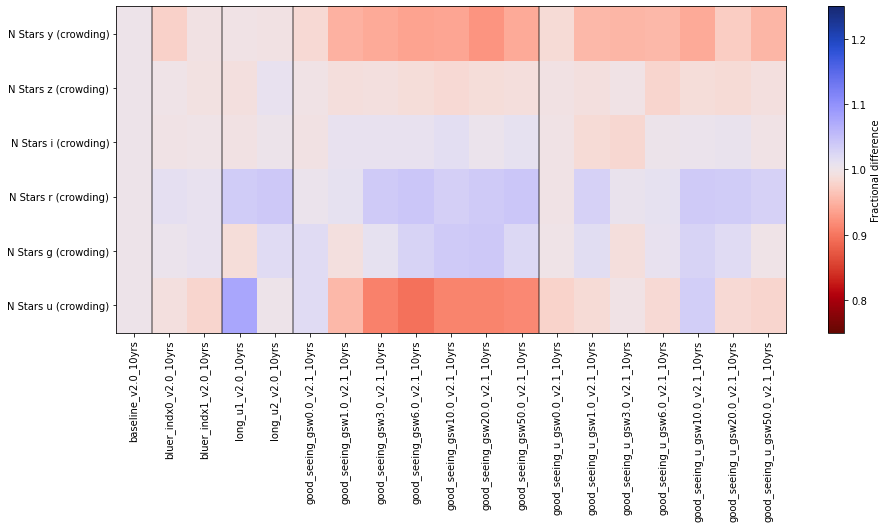

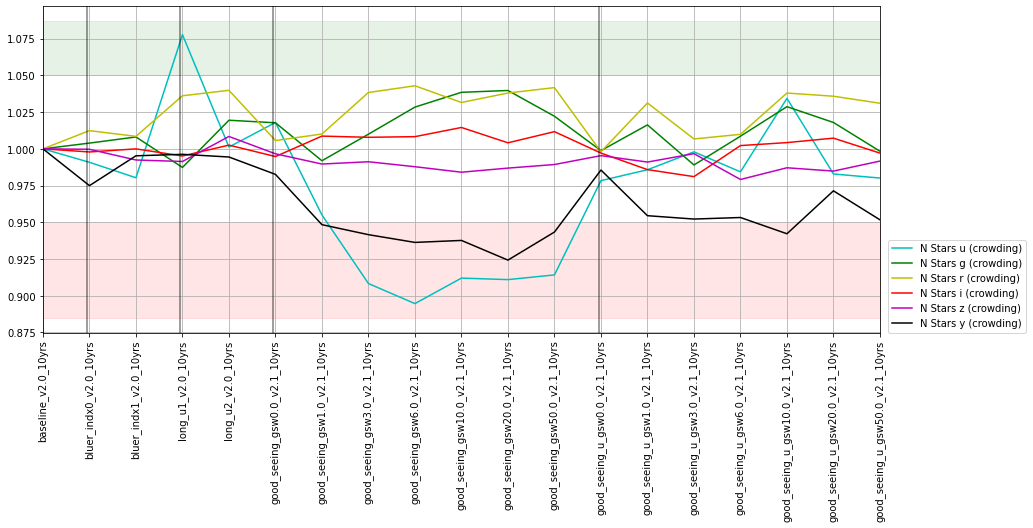

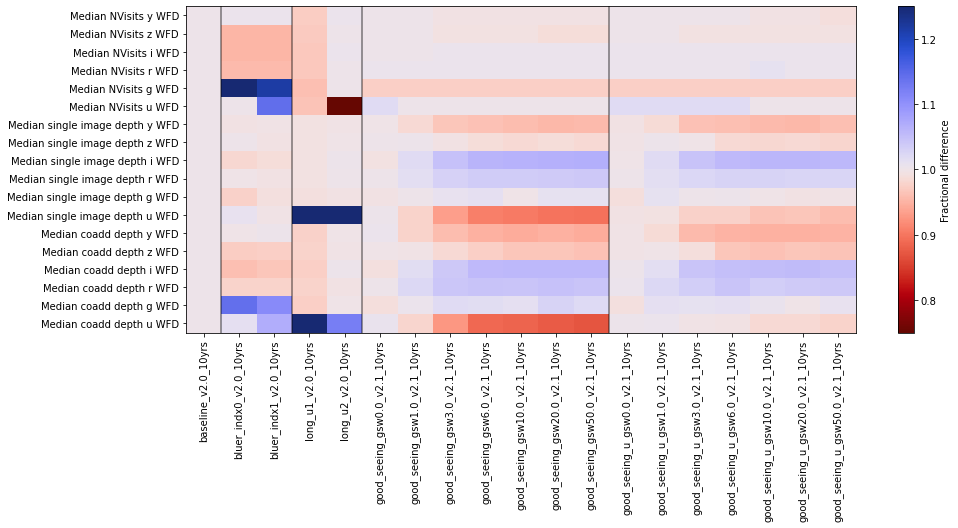

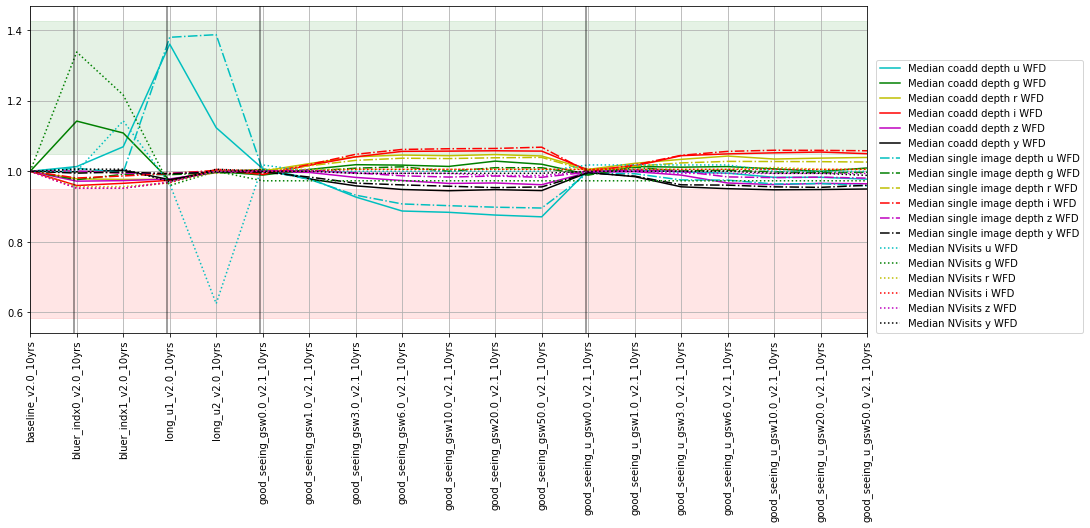

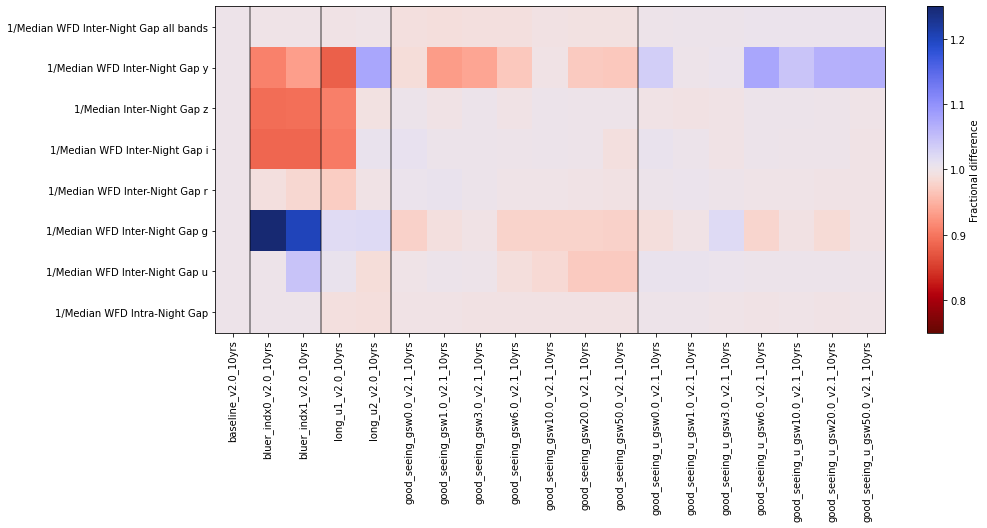

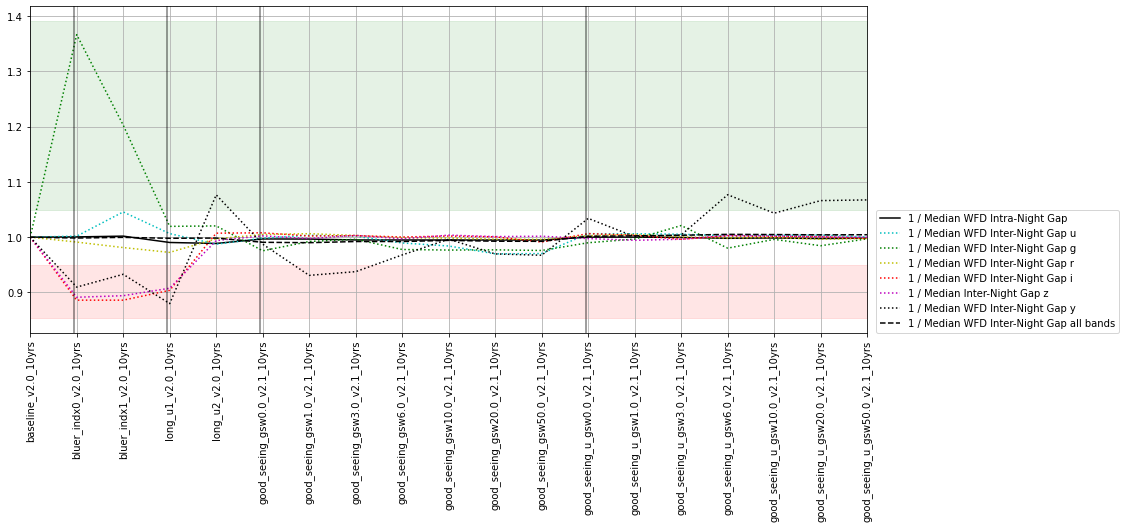

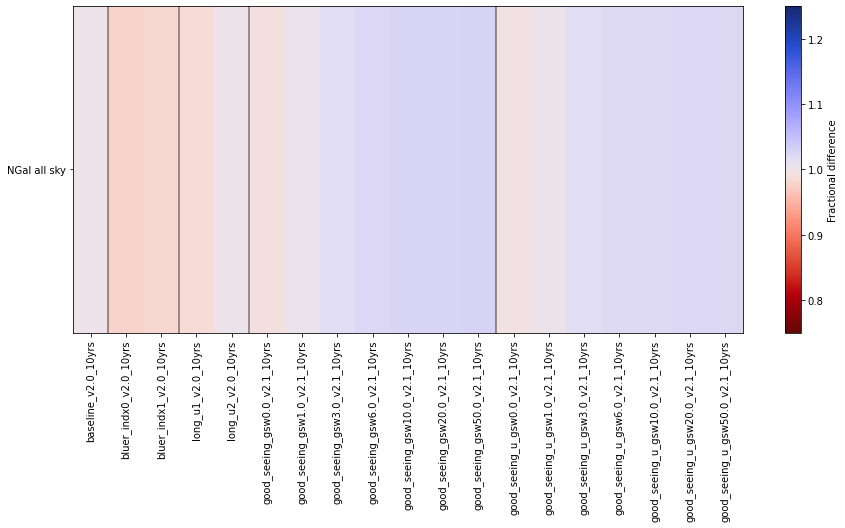

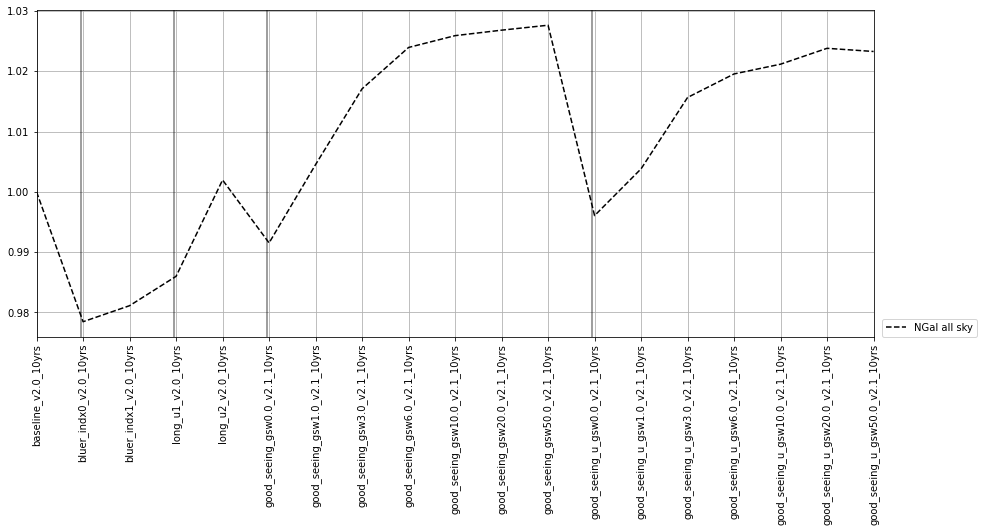

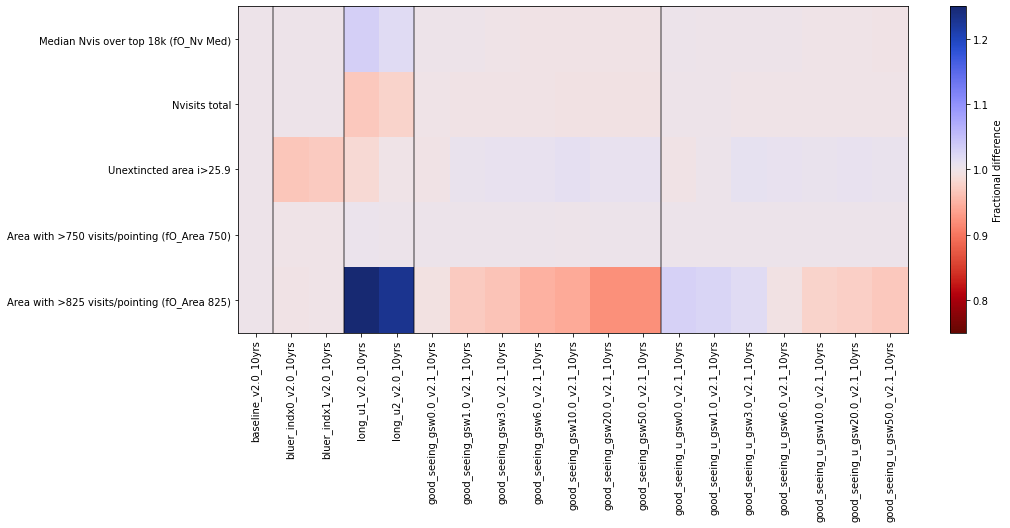

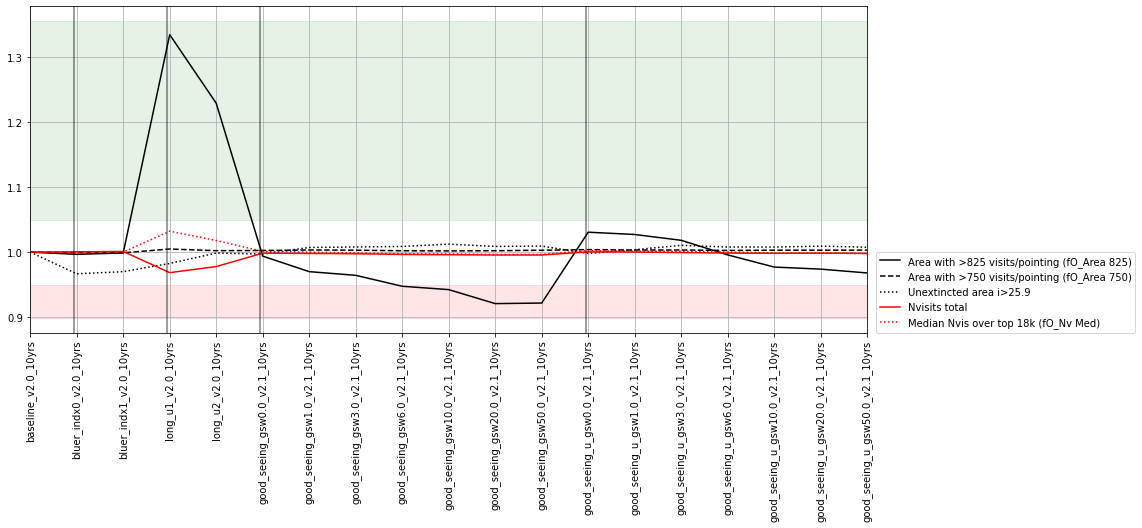

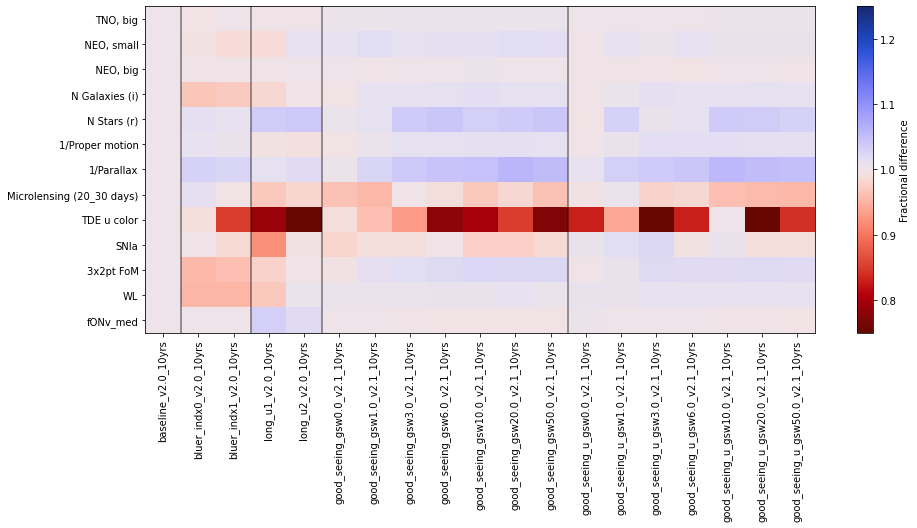

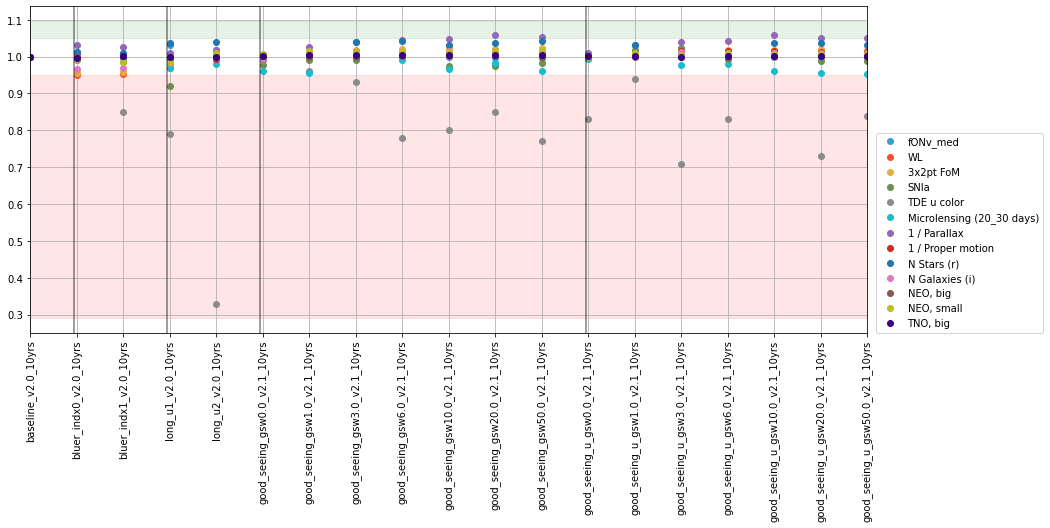

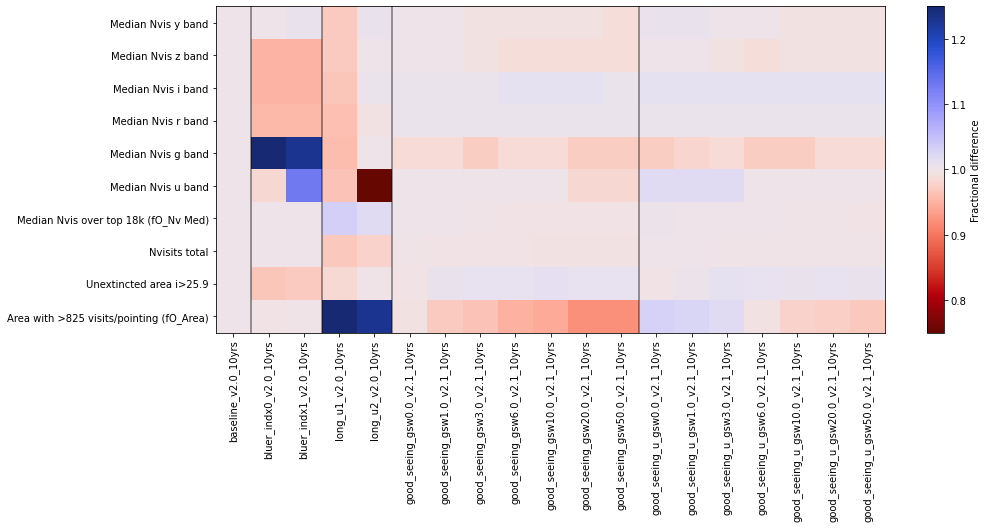

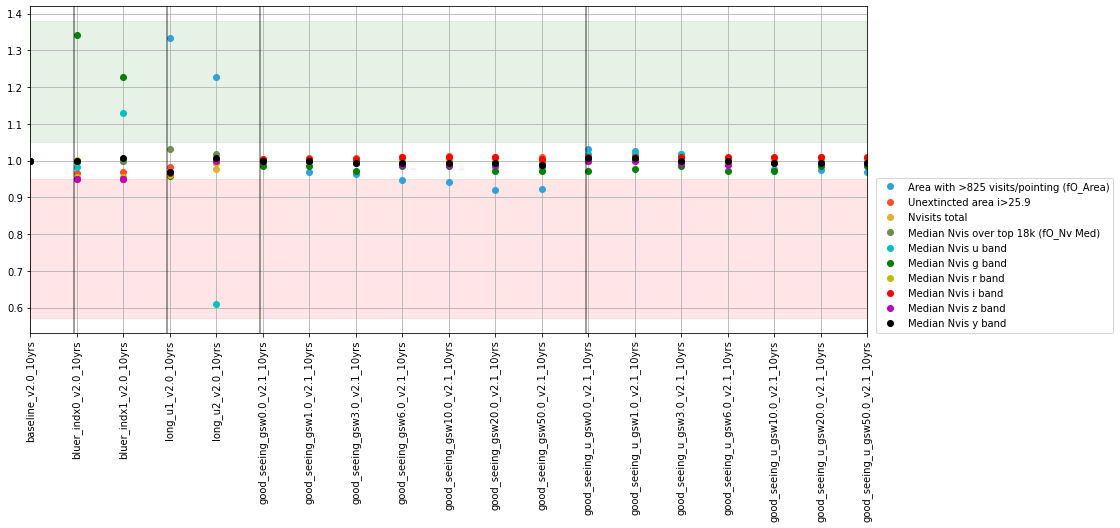

In [149]:
# Remaining metrics 
k_sets = [k for k in msets if not (k.startswith('AGN') or k.startswith('TVS') or k.startswith('GP ')
                                   or k.startswith('SSO') or k.startswith('DESC') or k.startswith('SRD')
                                  or k.startswith('SL'))]

for k in k_sets:
    msub = metric_set.loc[k]
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs,msub['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=msub['short_name'],
                                       metric_set=msub,
                                      color_range=0.5)
    fig.set_figwidth(15)
    for l in lines:
        ax.axvline(l, color='k', alpha=0.5)

    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_set.loc[k],
                                  metric_label_map=metric_set.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    #ax.set_ylim(0.5, 1.5)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

I didn't notice any strong preferences here, beyond those that would be expected (number of visits, etc.).